# SysArmy - Análisis de encuesta 2021.02

## 1. Carga y sanitización de datos

###  1.1. Definimos los metadatos asociados al dataset que vamos a analizar

In [ ]:
!pip install funpymodeling
from funpymodeling.exploratory import freq_tbl, status, profiling_num, cat_vars, num_vars

     |████████████████████████████████| 215 kB 5.7 MB/s 
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#%load_ext nb_black

csv_url = "https://raw.githubusercontent.com/openqube/openqube-sueldos/master/data/csv/argentina/2021.02.csv"

dataset_metadata = {
    "year": 2021,
    "part": 2,
    "skiprows": 0,
    "publish_date": "2021-08-23",
    "minimum_salary": 27216,  # https://es.wikipedia.org/wiki/Anexo:Salario_m%C3%ADnimo_en_Argentina
}

### 1.2. En base a los metadatos, cargamos el CSV, limpiamos columnas y las transformamos

In [ ]:
import pandas as pd
import io
import requests
from time import sleep
import matplotlib.pyplot as plt


raw_dataframe = None
source = requests.get(
    csv_url.format(dataset_metadata["year"], dataset_metadata["part"])
).content
raw_dataframe = pd.read_csv(
    io.StringIO(source.decode("utf-8")),
    skiprows=dataset_metadata["skiprows"],
    thousands=".",
   decimal=",",
)




# resultados que no pertenezcan a Argentina quedan fuera de este análisis
columns_to_remove = [
    "Bolivia",
    "Chile",
    "Colombia",
    "Cuba",
    "Costa Rica",
    "Ecuador",
    "El Salvador",
    "Guatemala",
    "Honduras",
    "México",
    "Nicaragua",
    "Panamá",
    "Paraguay",
    "Perú",
    "Puerto Rico",
    "República Dominicana",
    "Uruguay",
    "Venezuela",
]

#raw_dataframe.drop(columns_to_remove, axis=1, inplace=True)

import re

regex_white_chars = re.compile(r"\s+")
regex_non_alphanum = re.compile(r"\W+_?", re.I)

raw_dataframe.columns = (
    raw_dataframe.columns.str.strip()
    .str.lower()
    .str.replace(regex_white_chars, "_")
    .str.replace(regex_non_alphanum, "")
    .str.translate(
        "ñáéíóú".maketrans({"ñ": "n", "á": "a", "é": "e", "í": "i", "ó": "o", "ú": "u"})
    )
)

# Eliminamos los datos que no pertenezcan a Argentina
raw_dataframe = raw_dataframe[raw_dataframe["estoy_trabajando_en"] == "Argentina"]

dataframe = raw_dataframe.copy()

display([column for column in dataframe.columns])

['timestamp',
 'estoy_trabajando_en',
 'donde_estas_trabajando',
 'tipo_de_contrato',
 'salario_mensual_o_retiro_bruto_en_tu_moneda_local',
 'salario_mensual_o_retiro_neto_en_tu_moneda_local',
 'pagos_en_dolares',
 'cual_fue_el_ultimo_valor_de_dolar_que_tomaron',
 'que_tan_conforme_estas_con_tu_sueldo',
 'como_crees_que_esta_tu_sueldo_con_respecto_al_ultimo_semestre',
 'recibis_algun_tipo_de_bono',
 'a_que_esta_atado_el_bono',
 'tuviste_ajustes_por_inflacion_durante_2021',
 'de_que_fue_el_ajuste_total',
 'en_que_mes_fue_el_ultimo_ajuste',
 'trabajo_de',
 'anos_de_experiencia',
 'anos_en_la_empresa_actual',
 'anos_en_el_puesto_actual',
 'gente_a_cargo',
 'plataformas',
 'lenguajes_de_programacion_o_tecnologias',
 'frameworksherramientas_y_librerias',
 'bases_de_datos',
 'qa_testing',
 'ides',
 'cantidad_de_personas_en_tu_organizacion',
 'unnamed27',
 'actividad_principal',
 'la_recomendas_como_un_buen_lugar_para_trabajar',
 'como_calificas_las_politicas_de_diversidad_e_inclusion',
 'ben

### 1.3. Echamos un vistazo al dataframe previo a sanitizarlo

In [ ]:
raw_dataframe.T.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,6370,6371,6372,6373,6374,6375,6376,6377,6378,6379,6380,6381,6382,6383,6384,6385,6386,6387,6388,6389,6390,6391,6392,6393,6394,6395,6396,6397,6398,6399,6400,6401,6402,6403,6404,6405,6406,6407,6408,6409
timestamp,6/28/2021 11:59:46,6/28/2021 12:00:21,6/28/2021 12:03:10,6/28/2021 12:03:33,6/28/2021 12:03:51,6/28/2021 12:04:29,6/28/2021 12:07:41,6/28/2021 12:07:43,6/28/2021 12:10:14,6/28/2021 12:10:32,6/28/2021 12:13:05,6/28/2021 12:13:34,6/28/2021 12:13:36,6/28/2021 12:14:26,6/28/2021 12:18:11,6/28/2021 12:23:08,6/28/2021 12:23:25,6/28/2021 12:23:35,6/28/2021 12:27:05,6/28/2021 12:27:27,6/28/2021 12:28:05,6/28/2021 12:28:15,6/28/2021 12:39:11,6/28/2021 12:39:50,6/28/2021 12:40:09,6/28/2021 12:40:18,6/28/2021 12:46:36,6/28/2021 12:46:49,6/28/2021 12:49:30,6/28/2021 12:50:54,6/28/2021 12:51:25,6/28/2021 12:53:20,6/28/2021 13:01:59,6/28/2021 13:02:53,6/28/2021 13:04:18,6/28/2021 13:07:11,6/28/2021 13:08:33,6/28/2021 13:08:34,6/28/2021 13:12:16,6/28/2021 13:13:01,...,8/20/2021 13:03:14,8/20/2021 13:07:06,8/20/2021 13:15:11,8/20/2021 13:45:05,8/20/2021 13:53:33,8/20/2021 14:09:51,8/20/2021 14:21:50,8/20/2021 14:31:06,8/20/2021 14:32:00,8/20/2021 14:35:28,8/20/2021 14:35:52,8/20/2021 14:44:40,8/20/2021 15:25:39,8/20/2021 15:31:21,8/20/2021 15:32:59,8/20/2021 16:02:52,8/20/2021 16:51:15,8/20/2021 17:01:50,8/20/2021 17:10:50,8/20/2021 17:36:40,8/20/2021 19:50:23,8/20/2021 20:57:31,8/20/2021 21:35:44,8/20/2021 21:59:50,8/20/2021 22:15:46,8/20/2021 23:18:23,8/20/2021 23:47:56,8/21/2021 2:14:40,8/21/2021 8:47:33,8/21/2021 9:12:30,8/21/2021 11:01:53,8/21/2021 11:19:15,8/21/2021 12:14:38,8/21/2021 13:27:15,8/21/2021 14:17:21,8/21/2021 15:59:00,8/21/2021 16:58:51,8/21/2021 17:10:38,8/21/2021 19:21:29,8/21/2021 20:25:06
estoy_trabajando_en,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,...,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina
donde_estas_trabajando,Ciudad Autónoma de Buenos Aires,Río Negro,Ciudad Autónoma de Buenos Aires,Santa Fe,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Córdoba,Ciudad Autónoma de Buenos Aires,Córdoba,GBA,Ciudad Autónoma de Buenos Aires,Provincia de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,GBA,Provincia de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Corrientes,Córdoba,Provincia de Buenos Aires,Provincia de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Provincia de Buenos Aires,Ciudad Autónoma de Buenos Aires,Río Negro,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Tierra del Fuego,GBA,Entre Ríos,Provincia de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,...,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,GBA,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,La Pampa,Ciudad Autónoma de Buenos Aires,Ciudad

### 1.4. Sanitizamos/normalizamos datos que encontramos mal formados o repetidos

In [ ]:
import re


def normalize_dataframe_column(df_in, column_name, regex_assign_map):
    """
  Given a Dataframe (df), a column name that identifies the column to sanitize,
  applies an in-place replacement for each pair regex-value in the map
  """
    df_out = df_in.copy()
    for regex, value in regex_assign_map.items():
        compiled_regex = re.compile(regex, re.I)
        mask = df_in[column_name].str.strip().str.match(compiled_regex, na=False)
        df_out.loc[mask, column_name] = value

    # debug
    total, final = len(df_in[column_name].unique()), len(df_out[column_name].unique())
    display("reduced in {:02f}".format((total - final) / total))
    return df_out


def normalize_dataframe_column_replace(df_in, column_name, regex_replace_map):
    """
  Given a Dataframe (df), a column name that identifies the column to sanitize,
  applies an in-place replacement for each pair regex-value in the map
  """
    df_out = df_in.copy()
    for regex, pattern in regex_replace_map.items():
        compiled_regex = re.compile(regex, re.I)
        df_out[column_name] = (
            df_out[column_name].str.strip().str.replace(compiled_regex, pattern)
        )

    # debug
    total, final = len(df_in[column_name].unique()), len(df_out[column_name].unique())
    display("reduced in {:02f}".format((total - final) / total))
    return df_out

#### 1.4.1. Carreras

In [ ]:
dataframe = normalize_dataframe_column_replace(
    dataframe,
    "carrera",
    {
        "(Derecho|Abogac[íi]a|abogad.)": "Derecho",
        "(Contador.*)": "Contador Público",
        "(Arquitect(o|a|ura))": "Arquitectura",
        "(Lic.*)?Psicolog[íi]a": "Licenciatura en Psicología",
        "(Lic.*)?Marketing": "Licenciatura en Marketing",
        ".*Comunicación": "Licenciatura en Comunicación",
        "Letras": "Licenciatura en Letras",
        "Tec.*Infraestructuras{0,2}": "Tecnicatura Superior en Soporte de Infraestructuras",
        "(lic.*qu[ií]mica)": "Licenciatura en Química",
        "^(RRHH|Trabajo)": "Licenciatura en Relaciones del Trabajo",
        "(Lic.*)?Administraci[oó]n( de empresas)?": "Licenciatura en Administración de Empresas",
        "Ed.*f[ií]sica": "Educación Física",
        "Licenciatura en Cienciasdela Computación": "Licenciatura en Ciencias de la Computación",
        "Licenciatura en Ciencias dela Computación": "Licenciatura en Ciencias de la Computación",
        "(ningun(a|o)|-)": "DELETEME",
        "Lic.* Matemáticas?": "Licenciatura en Matemática",
        "(lic.*)econom[íi]a": "Licenciatura en Economía",
        "ingenier[íi]a de sistemas": "Ingeniería en Sistemas",
        "^(.*)\.$": "\\1",
    },
)

df = dataframe["carrera"].value_counts(sort=True)
display(df[:55])

'reduced in 0.123762'

Ingeniería en Sistemas de Información            593
Ingeniería en Informática                        347
Analista de Sistemas                             278
Licenciatura en Ciencias de la Computación       182
Licenciatura en Sistemas de Información          178
Licenciatura en Informática                      136
Tecnicatura en Programación                      112
Ingeniería Electrónica                            94
Diseño Gráfico                                    81
Tecnicatura Superior en Programación              78
Ingeniería en Computación                         63
Licenciatura en Administración de Empresas        59
Tecnicatura en Informática                        46
Licenciatura en Análisis de Sistemas              38
Analista Programador Universitario                33
Ingeniería Industrial                             32
Analista Programador                              30
Ingeniería en Telecomunicaciones                  29
Tecnicatura Superior en Sistemas Informáticos 

#### 1.4.2. Universidades

In [ ]:
# En Mendoza se asocia UM a la Universidad de Mendoza, y en Buenos Aires, a la Universidad de Morón
mask = dataframe.eval(
    'universidad in ["UM", "Um"] and donde_estas_trabajando == "Mendoza"'
)
dataframe.universidad.loc[mask] = "Universidad Nacional de Mendoza"
display(dataframe[mask].universidad)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Series([], Name: universidad, dtype: object)

In [ ]:
dataframe = normalize_dataframe_column(
    dataframe,
    "universidad",
    {
        "(UNSJ|.*Nacional de San Juan)": "UNSJ - Universidad Nacional de San Juan",
        "IRSO": "IRSO - Instituto Raúl Scalabrini Ortíz",
        "(UNPSJB|.*Patagonia San Juan Bosco.*)": "UNPSJB - Universidad Nacional de la Patagonia San Juan Bosco",
        "(UNSL|Universidad Nacional de San Luis)": "UNSL - Universidad Nacional de San Luis",
        "IFTS18": "IFTS18 - Instituto de Formación Técnica Superior N°18",
        "UCASAL": "UCASAL - Universidad Católica de Salta",
        "Universidad de Mendoza": "UM - Universidad de Mendoza",
        "UNTREF": "UNTREF - Universidad Nacional de Tres de Febrero",
        "(UNL[uU]|Universidad Nacional de Luj[aá]n)": "UNLu - Universidad Nacional de Luján",
        "(UAA|.*Atl[aá]ntida.*)": "UAA - Universidad Atlántida Argentina",
        "([fF]?IUPFA)": "IUPFA - Instituto Universitario de la Policía Federal Argentina",
        "([uU]?FASTA)": "FASTA - Fraternidad de Agrupaciones Santo Tomás de Aquino",
        "(UCSE)": "UCSE - Universidad Católica de Santiago del Estero",
        "(ISIV|.*Virasoro.*)": "ISIV - Instituto Superior de Informática Virasoro",
        "(UN[Aa]M)": "UNaM - Universidad Nacional de Misiones",
        "(-|ninguna)$": "DELETEME",
    },
)

df = dataframe["universidad"].value_counts(sort=True)
display(df[:60])

'reduced in 0.103734'

UTN - Universidad Tecnológica Nacional                                        734
UBA - Universidad de Buenos Aires                                             468
UADE - Universidad Argentina De la Empresa                                    125
UNLaM - Universidad Nacional de La Matanza                                    116
UNLP - Universidad Nacional de La Plata                                        97
UAI - Universidad Abierta Interamericana                                       81
UNC - Universidad Nacional de Córdoba                                          66
ORT                                                                            56
UP - Universidad de Palermo                                                    56
Universidad Siglo 21                                                           56
UNR - Universidad Nacional de Rosario                                          42
UNICEN - Universidad Nacional del Centro de la Provincia de Buenos Aires       40
UNQ - Universida

#### 1.4.3. Experiencia

In [ ]:
dataframe["anos_de_experiencia"] = dataframe["anos_de_experiencia"].astype(int)
dataframe["anos_en_la_empresa_actual"] = dataframe["anos_en_la_empresa_actual"].astype(
    int
)
dataframe["anos_en_el_puesto_actual"] = dataframe["anos_en_el_puesto_actual"].astype(
    int
)

#### 1.4.4. Regiones

In [ ]:
dataframe = normalize_dataframe_column(
    dataframe,
    "donde_estas_trabajando",
    {"(GBA|Provincia de Buenos Aires)": "Buenos Aires",},
)

display(dataframe["donde_estas_trabajando"].unique())

'reduced in 0.040000'

array(['Ciudad Autónoma de Buenos Aires', 'Río Negro', 'Santa Fe',
       'Córdoba', 'Buenos Aires', 'Corrientes', 'Tierra del Fuego',
       'Entre Ríos', 'Mendoza', 'Chubut', 'Tucumán', 'Neuquén',
       'Catamarca', 'Misiones', 'La Rioja', 'Jujuy', 'Salta', 'Chaco',
       'San Juan', 'La Pampa', 'Formosa', 'Santiago del Estero',
       'Santa Cruz', 'San Luis'], dtype=object)

#### 1.4.5. Discapacidad

In [ ]:
dataframe = normalize_dataframe_column(
    dataframe,
    "tenes_algun_tipo_de_discapacidad",
    {
        "^(_|-|no( tengo)?|ningun[oa]|nada|0|ni)$": None,
        ".*auditiv[oa].*": "Auditiva",
        ".*visual.*": "Visual",
        "mental": "Mental",
        "motriz": "Motriz",
        "vis?ceral": "Visceral",
        "^(sobrepeso|obesidad)": "Obesidad",
    },
)

df = dataframe["tenes_algun_tipo_de_discapacidad"].value_counts(sort=True)
display(df[:6])

'reduced in 0.340000'

Visual      151
Mental       16
Auditiva     13
Motriz        6
Visceral      3
Obesidad      3
Name: tenes_algun_tipo_de_discapacidad, dtype: int64

#### 1.4.5. Roles

In [ ]:
dataframe = normalize_dataframe_column_replace(
    dataframe,
    "trabajo_de",
    {
        "Project Manager.*": "Project Manager",
        "Director, Product Manager, Project Manager": "Manager / Director",
        "Technical Leader.*": "Technical Leader",
        "Team Leader.*": "Technical Leader",
        "Full ?Stack Developer": "Developer",
        "Seguridad Inform[aá]tica": "Infosec",
        "(profesor|instructor|educador|docente|capacitador.*)": "Docente",
        "^(Soporte T[ée]cnico|Technical support|Support)": "Technical Support",
        "Software Engineer": "Developer",
        "(Analista )?programador": "Developer",
        "Analista Funcional": "Functional Analyst",
        "Technical Functional Analyst": "Functional Analyst",
        "administrativo": "Administrativo",
        "^cto.*": "CTO",
        "Asistant": "Assistant",
        "helpdesk": "HelpDesk",
        "(Analista de seguridad|Security.*)": "Infosec",
        "BI Leader": "BI Analyst / Data Analyst"
    },
)

df = dataframe["trabajo_de"].value_counts(sort=True)
display(df[0:80])

'reduced in 0.094286'

Developer                   2637
SysAdmin / DevOps / SRE      688
Technical Leader             399
QA / Tester                  282
Manager / Director           276
                            ... 
DBA / Developer                1
CloudEngineer/Dev/DevOps       1
Sr Staff engineer              1
Functional Analyst sr          1
Sistemas                       1
Name: trabajo_de, Length: 80, dtype: int64

#### 1.4.6. Salario (corrección de numeración)

In [ ]:
# Algunos salarios están cargados, pareciera ser, en miles

#### 1.4.7. Sueldo dolarizado (modificado)

In [ ]:
mask = dataframe.pagos_en_dolares.str.contains("dolarizado", na=False)
column_name = "sueldo_dolarizado"

dataframe.loc[~mask, column_name] = False
dataframe.loc[mask, column_name] = True
dataframe.loc[:, column_name] = dataframe["sueldo_dolarizado"].astype(bool)

### 1.5. Agregamos columnas calculadas

In [ ]:
dataframe["seniority"] = pd.cut(
    dataframe["anos_de_experiencia"].values,
    [-1, 2, 5, 50],
    labels=["Junior", "Semi-Senior", "Senior"],
)
display(dataframe["seniority"])

0       Semi-Senior
1            Senior
2            Junior
3       Semi-Senior
4            Senior
           ...     
6405         Senior
6406         Senior
6407    Semi-Senior
6408         Senior
6409         Senior
Name: seniority, Length: 6410, dtype: category
Categories (3, object): ['Junior' < 'Semi-Senior' < 'Senior']

### 1.6. Eliminamos outliers

In [ ]:
salary_debug_columns = [
    "tengo",
    "anos_de_experiencia",
    "estoy_trabajando_en",
    "tipo_de_contrato",
    "salario_mensual_bruto_en_tu_moneda_local",
]


def remove_outlier(df_in, col_name, iqr_factor=1.5):
    """
  IQR outliers removal (https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)
  accept a dataframe, remove outliers, return cleaned data in a new dataframe
  see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
  """
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1  # interquartile range
    fence_low = q1 - iqr_factor * iqr
    fence_high = q3 + iqr_factor * iqr
    df_inliers = df_in.loc[
        (df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)
    ]
    df_outliers = df_in.loc[
        (df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)
    ]
    return df_inliers, df_outliers

#### 1.6.1. Salarios

In [ ]:
dataframe.loc[:, "_sal"] = dataframe[
    "salario_mensual_o_retiro_bruto_en_tu_moneda_local"
]

In [ ]:
dataframe["salario_mensual_o_retiro_bruto_en_tu_moneda_local"] = (
    dataframe["_sal"]
    .str.replace(".", "")
    .str.replace(",", ".")
    .str.replace("$", "")
    .str.replace(r"[^0-9\.]", "")
    .str.replace(r"^\s*$", "0")
    .fillna(0)
    .astype(float)
)

df_inliers, df_outliers = remove_outlier(
    dataframe, "salario_mensual_o_retiro_bruto_en_tu_moneda_local", 3.5
)

# inliers percent over total
display(len(df_inliers) / len(dataframe))

# display outliers
#display(df_outliers[salary_debug_columns])

0.9642745709828393

In [ ]:
minimum_salary = dataset_metadata["minimum_salary"]
df_outliers_lower_limit = df_inliers.query(
    "salario_mensual_o_retiro_bruto_en_tu_moneda_local < @minimum_salary/2.0"
)
display(len(df_outliers_lower_limit))
#display(df_outliers_lower_limit[salary_debug_columns])   #1
df_inliers_lower_limit = df_inliers.query(
    "salario_mensual_o_retiro_bruto_en_tu_moneda_local >= @minimum_salary/2.0"
)

dataframe = df_inliers_lower_limit

305

Gender Preprocessing

In [ ]:
df = dataframe

gender_txs = {
    "Hombre Cis": "(varón cis|varón|varon|masculino|varón cis heterosexual|.*varón cis.*|.*varon y punto|macho alfa|.*soy varon|.*helic[oó]ptero|.*apache|machote|optimus prime|macho|sexo masculino|peronista|humano masculino|velociraptor|.*pekemen|.*hijo de puta|.*gargola|tortuga|robot mutante|unicornio|.*poste de luz|dinosaurio|hormiga|.*interplanetario|.*ventilador de techo|.*persona|herero)",
    "Mujer Cis": "(mujer cis|mujer|soy mujer)",
    "Hombre Trans": "varón trans",
    "Mujer Trans": "(mujer trans|travesti|femenino pero mi DNI dice masculino|trans queer)",
    "Prefiero No Decir": "(prefiero no decir|les importa\?|completamente irrelevante|.*pelotude[zs].*|basta|No entiendo|.*preguntas de mierda|.*nada que ver|.*romper los huevos|.*boludeces|no tiene sentido esto|wtf|que puta te importa|no es importante|es necesario esto|dejen de romper|dejen de preguntar|que pelotudés|no interesa|.*esta pregunta pelotuda|ns/nc|.*boludez|.*que mierda es esto|no tengo ni idea|nose cual elegir|.*que sea para pelotudos|.*no se que poner|\?\?\?|.*crear etiquetas|.*me marearon|.*me visto de mujer|^m$|Otre|.*idioma inclusivo|y el gay|.*pregunta mas rebuscada)",
    "No Binarie": "no binarie",
    "Agénero": "agénero",
}

for label, regex in gender_txs.items():
    ix = df.me_identifico.str.match(regex, case=False,na=False)
    df.loc[ix, "me_id_extra"] = label


df.me_id_extra.value_counts() / len(df)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


Hombre Cis           0.761232
Mujer Cis            0.164738
Prefiero No Decir    0.041695
No Binarie           0.006637
Hombre Trans         0.001702
Mujer Trans          0.001532
Agénero              0.000170
Name: me_id_extra, dtype: float64

In [ ]:
# these are the genders that have at least 0.5% of responses
enough_data = ["Hombre Cis", "Mujer Cis", "Prefiero No Decir", "No Binarie"]

### 1.7 Helper functions

In [ ]:
def invert_non_representative_values(
    dataframe,
    column,
    representative_values,
    value_column="salario_mensual_o_retiro_bruto_en_tu_moneda_local",
):
    df.loc[
        df.eval("{} not in @representative_values".format(column)), value_column
    ] *= -1
    return df


def filter_valid_top_values(
    dataframe,
    column,
    top_values,
    value_column="salario_mensual_o_retiro_bruto_en_tu_moneda_local",
):
    return dataframe.query(
        '{} in @top_values & {} != "DELETEME"'.format(column, column)
    )


def get_two_dimensional_median_with_outliers_filtered(
    dataframe, group_by_columns, value_column="salario_mensual_o_retiro_bruto_en_tu_moneda_local"
):
    """
  Given a dataframe, groups data by the first given column in group_by_columns, computes median
  and sets to zero all values that have less than 5% of representation on the second column
  """
    dfl = (
        dataframe.groupby(group_by_columns)
        .size()
        .to_frame()
        .groupby(level=0)
        .apply(lambda x: x / float(x.sum()))
        .rename(columns={0: "population"})
        .query("population > 0.05")
        .drop(columns=["population"])
        .reset_index()
    )
    dfr = (
        dataframe.groupby(group_by_columns)
        .median()[value_column]
        .fillna(0)
        .to_frame()
        .reset_index()
    )
    return (
        pd.merge(dfl, dfr, on=group_by_columns, how="inner")
        .groupby(group_by_columns)
        .min()
        .unstack(group_by_columns[1])[value_column]
        .fillna(0)
    )

## 2. Análisis de resultados

Análisis exploratorio de los datos, los resultados se exportan en un JSON llamado 'charts'

In [ ]:
charts = {
    "total_surveyed": len(raw_dataframe),
    "total_analyzed_surveyed": len(dataframe),
}

display(charts)


def to_rechart(df, max=0):
    """
  if max is set, groups the exceeded rows into 'Otros' column, summing values
  """
    if max != 0:
        # df = df.sort_values(by, ascending=False)
        others = df[max:].sum()
        df = df[:max]
        df.loc["Otros"] = others
    return {
        "data": [
            {"name": str(name), **(data if isinstance(data, dict) else {"value": data})}
            for name, data in df.T.to_dict().items()
        ],
    }

{'total_analyzed_surveyed': 5876, 'total_surveyed': 6410}

### 2.1. Perfiles

#### 2.1.1. Regiones

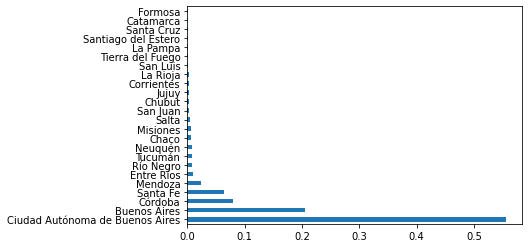

In [ ]:
df = dataframe["donde_estas_trabajando"].value_counts(normalize=True, sort=True)

df.plot(kind="barh", logx=False)
charts["regions_percent"] = to_rechart(df)

#### 2.1.2. Roles (Posición, Open Source, Hobbie)

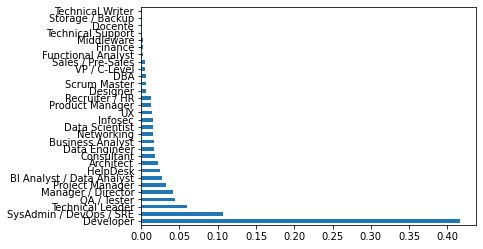

In [ ]:
df = dataframe["trabajo_de"].value_counts(normalize=True, sort=True)

df[:30].plot.barh()
charts["roles_percent"] = to_rechart(df, 30)

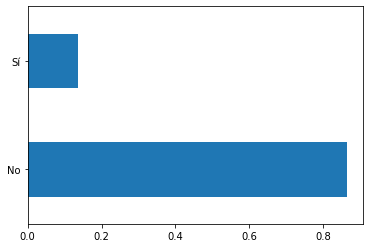

In [ ]:
df = dataframe["contribuis_a_proyectos_open_source"].value_counts(
    normalize=True, sort=True
)

df.plot.barh()
charts["opensource_percent"] = to_rechart(df)

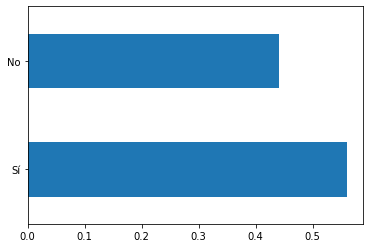

In [ ]:
df = dataframe["programas_como_hobbie"].value_counts(normalize=True, sort=True)

df.plot.barh()
charts["hobbie_percent"] = to_rechart(df)

#### 2.1.3. Experiencia

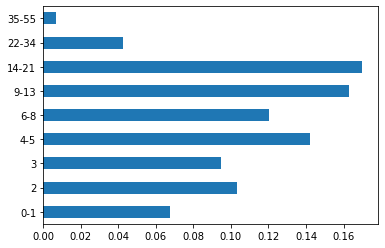

In [ ]:
df = dataframe["anos_de_experiencia"].copy()
df = df.groupby(
    pd.cut(
        df.values,
        [0, 1, 2, 3, 5, 8, 13, 21, 34, 55],
        labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-34", "35-55"],
    )
).count() / len(df)

df.plot.barh()
charts["experience_years_percent"] = to_rechart(df.sort_index())

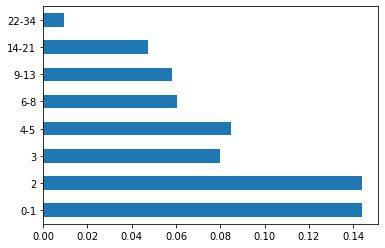

In [ ]:
df = dataframe["anos_en_la_empresa_actual"].copy()
df = df.groupby(
    pd.cut(
        df.values,
        [0, 1, 2, 3, 5, 8, 13, 21, 34],
        labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-34"],
    )
).count() / len(df)

df.plot.barh()
charts["experience_years_in_company"] = to_rechart(df.sort_index())

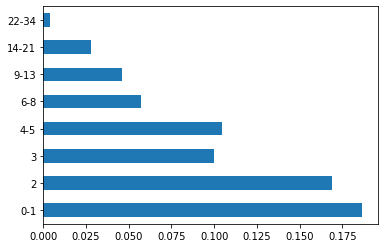

In [ ]:
df = dataframe["anos_en_el_puesto_actual"].copy()
df = df.groupby(
    pd.cut(
        df.values,
        [0, 1, 2, 3, 5, 8, 13, 21, 34],
        labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-34"],
    )
).count() / len(df)

df.plot.barh()
charts["experience_years_in_position"] = to_rechart(df.sort_index())

#### 2.1.4. Educación

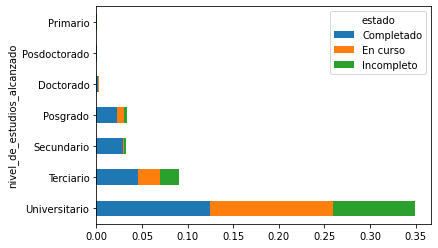

In [ ]:
df = dataframe.groupby(["nivel_de_estudios_alcanzado", "estado"])[
    "nivel_de_estudios_alcanzado"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado"], ascending=False
) / len(
    dataframe
)

df.plot(kind="barh", stacked=True, logx=False)
charts["education_stacked"] = to_rechart(df)

29.38

Index(['Ingeniería en Sistemas de Información', 'Ingeniería en Informática',
       'Analista de Sistemas', 'Licenciatura en Sistemas de Información',
       'Licenciatura en Ciencias de la Computación',
       'Licenciatura en Informática', 'Tecnicatura en Programación',
       'Ingeniería Electrónica', 'Tecnicatura Superior en Programación',
       'Diseño Gráfico', 'Ingeniería en Computación',
       'Licenciatura en Administración de Empresas',
       'Tecnicatura en Informática', 'Licenciatura en Análisis de Sistemas',
       'Analista Programador Universitario', 'Ingeniería Industrial',
       'Tecnicatura Superior en Sistemas Informáticos', 'Analista Programador',
       'Ingeniería en Telecomunicaciones', 'Diseño Multimedial',
       'Analista de Computación', 'Licenciatura en Psicología',
       'Tecnicatura en Sistemas', 'Ingeniería en Software',
       'Tecnicatura Superior en Análisis de Sistemas',
       'Analista Universitario de Sistemas', 'Telecomunicaciones',
       'T

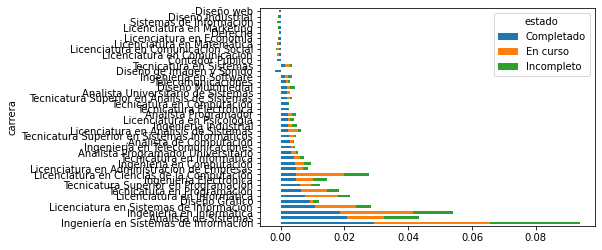

In [ ]:
# Para el grado de completitud por carrera se tendrá en cuenta el tamaño de la muestra, se considerarán insuficientes los datos de aquellas carreras que representen menos del 0.5% del total

df = (
    dataframe["carrera"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
    .query("carrera > 0.005")
)

display(len(dataframe["carrera"]) * 0.005)
chosen_careers = df.index
display(chosen_careers)

df = dataframe.query('carrera != "DELETEME"')["carrera"].value_counts(
    normalize=True, sort=True
)
charts["careeres_percent"] = to_rechart(df, 40)

df = dataframe.query('carrera != "DELETEME"').groupby(["carrera", "estado"])[
    "carrera"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado", "En curso"], ascending=False
) / len(
    dataframe
)

df.loc[
    df.eval("carrera not in @chosen_careers"), ["Completado", "En curso", "Incompleto"]
] *= -1

df[:40].plot(kind="barh", stacked=True, logx=False)
charts["careeres_stacked_percent"] = to_rechart(df[:40])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


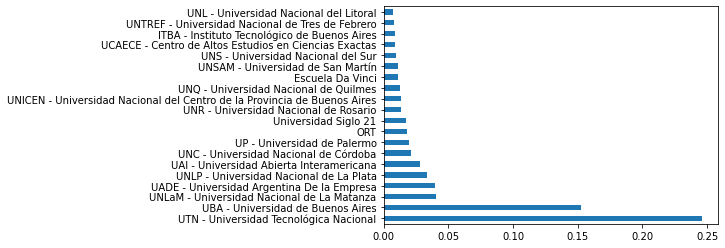

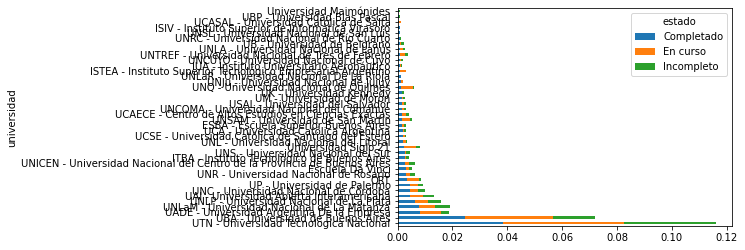

In [ ]:
df = dataframe.query('universidad != "DELETEME"')["universidad"].value_counts(
    normalize=True, sort=True
)

df[:20].plot(kind="barh")
charts["universities_percent"] = to_rechart(df, 40)

df = dataframe.query('universidad != "DELETEME"').groupby(["universidad", "estado"])[
    "universidad"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado", "En curso"], ascending=False
) / len(
    dataframe
)

df[:40].plot(kind="barh", stacked=True, logx=False)
charts["universities_stacked_percent"] = to_rechart(df, 40)

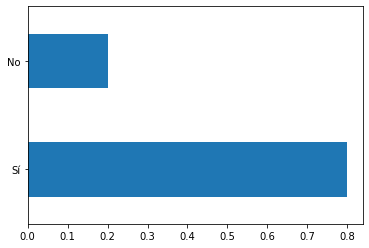

In [ ]:
dc = pd.DataFrame(
    {
        "realizaste_cursos_de_especializacion": dataframe[
            "realizaste_cursos_de_especializacion"
        ].dropna()
    }
)
dc

mask = dc["realizaste_cursos_de_especializacion"].str.contains("Sí")
dc.loc[mask, "hizo_curso"] = "Sí"
dc.loc[~mask, "hizo_curso"] = "No"

df = dc["hizo_curso"].value_counts(normalize=True, sort=True)

df.plot(kind="barh")
charts["specialization_percent"] = to_rechart(df)

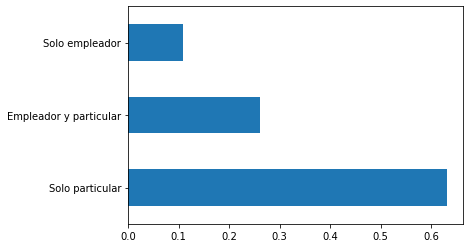

In [ ]:

mask_empleador = dc["realizaste_cursos_de_especializacion"].str.contains("un empleador")
mask_particular = dc["realizaste_cursos_de_especializacion"].str.contains(
    "de forma particular"
)

dc.loc[mask_particular, "quien_paga"] = "Solo particular"
dc.loc[mask_empleador, "quien_paga"] = "Solo empleador"
dc.loc[mask_empleador & mask_particular, "quien_paga"] = "Empleador y particular"

df = dc["quien_paga"].value_counts(normalize=True, sort=True)

df.plot(kind="barh")
charts["specialization_pays_percent"] = to_rechart(df)

#### 2.1.5. Demografía

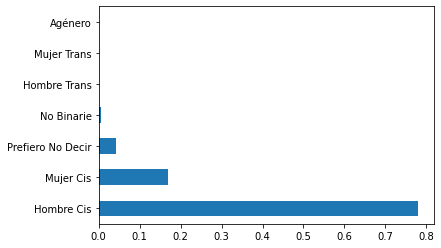

In [ ]:
df = dataframe["me_id_extra"].value_counts(normalize=True, sort=True)

df.plot(kind="barh")
charts["demographics_gender_percent"] = to_rechart(df)

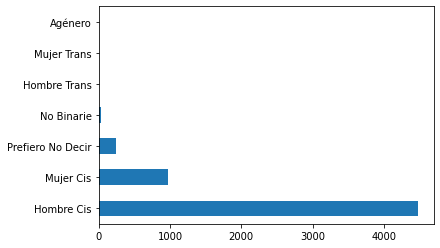

In [ ]:
df = dataframe["me_id_extra"].value_counts(normalize=False, sort=True)

df.plot(kind="barh")
charts["demographics_gender_absolute"] = to_rechart(df)

In [ ]:
id_sexual_df = pd.read_csv("https://raw.githubusercontent.com/openqube/openqube-sueldos/master/data/Orientacion%20sexual%202021.02.csv")

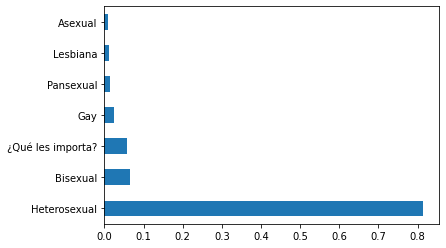

In [ ]:
df = id_sexual_df["Identidad sexual"].value_counts(normalize=True, sort=True)

df[:7].plot(kind="barh")
charts["demographics_sexual_orientation_percent"] = to_rechart(df, 7)

'demographics_laboral_violence'

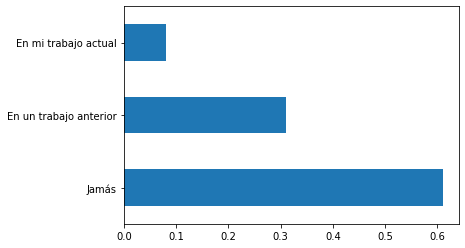

In [ ]:

df = dataframe["sufriste_o_presenciaste_situaciones_de_violencia_laboral"].value_counts(normalize=True, sort=True)

demographics_laboral_violence_ever = df['En un trabajo anterior'] + df['En mi trabajo actual']
demographics_laboral_violence_ever = pd.Series(demographics_laboral_violence_ever)

df.plot(kind="barh")
charts["demographics_laboral_violence"] = to_rechart(df)
charts["demographics_laboral_violence_ever"] = to_rechart(demographics_laboral_violence_ever)

'demographics_laboral_violence'

### 2.2. Salarios

#### 2.2.1. Progresión Histórica

https://colab.research.google.com/drive/10e5hZytlMatMuKmLCRo9YzpS1O9EbeV2#scrollTo=Pc5mUvyozCQ5

#### 2.2.2. Región

In [ ]:
# Para el análisis regional se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas regiones que representen menos del 0.5% del total

df = (
    dataframe["donde_estas_trabajando"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
    .query("donde_estas_trabajando > 0.005")
)

display(len(dataframe["donde_estas_trabajando"]) * 0.005)
chosen_regions = df.index
display(chosen_regions)

29.38

Index(['Ciudad Autónoma de Buenos Aires', 'Buenos Aires', 'Córdoba',
       'Santa Fe', 'Mendoza', 'Entre Ríos', 'Río Negro', 'Tucumán', 'Neuquén',
       'Chaco', 'Misiones'],
      dtype='object')

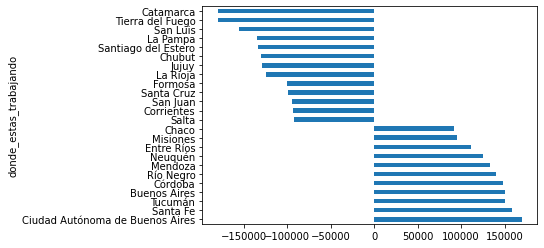

In [ ]:
# Éstas serán convertidas a valores negativos, de manera de poder distinguirlas sin perjudicar a quienes deseen
# observar los resultados más allá del tamaño muestral acotado

df = dataframe.copy()

df.loc[
    df.eval("donde_estas_trabajando not in @chosen_regions"),
    "salario_mensual_o_retiro_bruto_en_tu_moneda_local",
] *= -1
df = (
    df.groupby(["donde_estas_trabajando"])
    .median()
    .unstack()["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .sort_values(ascending=False)
)

df.plot(kind="barh")
charts["regions_salary_median"] = to_rechart(df)

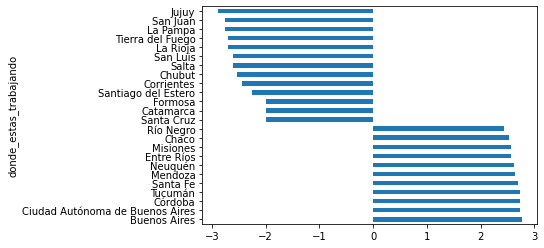

In [ ]:
df = dataframe.copy()
df.loc[
    df.eval("donde_estas_trabajando not in @chosen_regions"),
    "que_tan_conforme_estas_con_tu_sueldo",
] *= -1
df = (
    df.groupby(["donde_estas_trabajando"])
    .mean()
    .unstack()["que_tan_conforme_estas_con_tu_sueldo"]
    .sort_values(ascending=False)
)

df.plot(kind="barh")
charts["regions_salary_acquiescence"] = to_rechart(df)

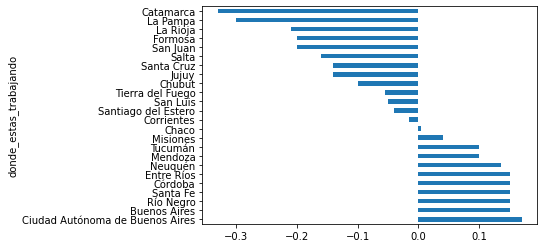

In [ ]:
df = dataframe.copy()
df.loc[
    df.eval("donde_estas_trabajando not in @chosen_regions"),
    "de_que_fue_el_ajuste_total",
] *= -1
df = (
    df.groupby(["donde_estas_trabajando"])
    .median()
    .unstack()["de_que_fue_el_ajuste_total"]
    .sort_values(ascending=False)
    / 100
)

df.plot(kind="barh")
charts["regions_salary_adjustment"] = to_rechart(df)

##### 2.2.2.1. Región (mínimos por seniority) - no incluídos en el reporte

In [ ]:
df = (
    dataframe.query("donde_estas_trabajando in @chosen_regions")
    .groupby(["donde_estas_trabajando", "seniority"])[
        "salario_mensual_o_retiro_bruto_en_tu_moneda_local"
    ]
    .min()
    .unstack()
    .sort_values(by=["Senior"], ascending=False)
)
display(df)

seniority,Junior,Semi-Senior,Senior
donde_estas_trabajando,,,
Río Negro,45000.0,37000.0,70000.0
Neuquén,66000.0,40000.0,60000.0
Tucumán,25000.0,84000.0,52150.0
Santa Fe,15670.0,44000.0,50000.0
Misiones,40000.0,31000.0,45800.0
Chaco,35000.0,27500.0,42000.0
Entre Ríos,25000.0,14400.0,40000.0
Mendoza,30000.0,31500.0,23000.0
Buenos Aires,15000.0,18000.0,22000.0




```
# This is formatted as code
```

##### 2.2.2.2. Región (máximos por seniority) - no incluídos en el reporte

In [ ]:
df = (
    dataframe.query("donde_estas_trabajando in @chosen_regions")
    .groupby(["donde_estas_trabajando", "seniority"])[
        "salario_mensual_o_retiro_bruto_en_tu_moneda_local"
    ]
    .max()
    .unstack()
    .sort_values(by=["Senior"], ascending=False)
)
display(df)

seniority,Junior,Semi-Senior,Senior
donde_estas_trabajando,,,
Buenos Aires,650000.0,765000.0,774000.0
Ciudad Autónoma de Buenos Aires,540000.0,774000.0,770000.0
Mendoza,230000.0,450000.0,770000.0
Santa Fe,580000.0,625000.0,770000.0
Córdoba,640000.0,720000.0,769700.0
Río Negro,544000.0,531250.0,750000.0
Tucumán,450000.0,470000.0,730000.0
Neuquén,182000.0,576000.0,700000.0
Entre Ríos,256140.0,260000.0,547200.0


#### 2.2.3. Puesto

##### 2.2.3.1. Seniority

(metodología vieja, queda sólo para reproducir reportes previos)

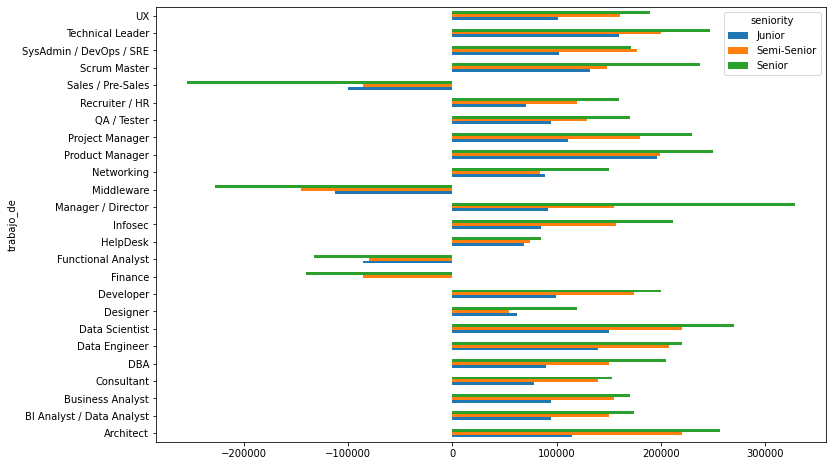

In [ ]:
# Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total

df = (
    dataframe["trabajo_de"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
    .query("trabajo_de > 0.005")
)

chosen_roles = list(df.index)
excluded_roles = {
    "VP / C-Level"
}  # Excluído porque no contaba con todas las seniorities

df = dataframe["trabajo_de"].value_counts(normalize=True, sort=True)
candidate_roles = list(df[:26].index)
top_roles = [r for r in candidate_roles if r not in excluded_roles]

df = (
    dataframe.query("trabajo_de in @top_roles")
    .groupby(["trabajo_de", "seniority"])
    .median()
    .unstack("seniority")["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .fillna(0)
)  # .sort_values(by=['salario_mensual_bruto_en_tu_moneda_local'], ascending=False)

df.loc[
    df.eval("trabajo_de not in @chosen_roles"), ["Junior", "Semi-Senior", "Senior"]
] *= -1

plt.figure(figsize=(12, 8))
df.plot(kind="barh", ax=plt.gca())
charts["roles_seniority_salary_median"] = to_rechart(df[:30])

##### 2.2.3.1. Seniority

La metodología previa consideraba a una `position` con "suficientes datos" si la sumatoria de todas sus seniorities (junior, senior, semisr) contenía al menos un 0.5% del total de las respuestas.

La nueva metodología considera cada combinación (`position`, `seniority`) con suficientes datos si hay al menos 6 valores para obtener la mediana.

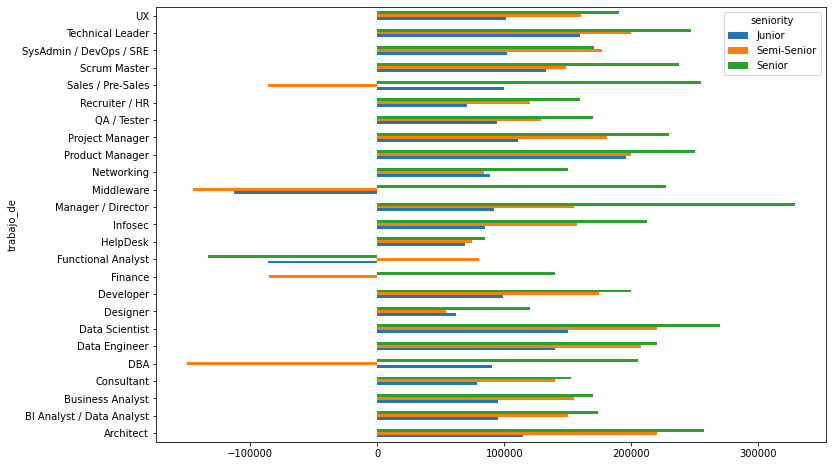

In [ ]:
salary_df = dataframe.copy()[dataframe.seniority.notna()]
salary_df['position_and_seniority'] = salary_df[["trabajo_de", "seniority"]].agg('__'.join, axis=1)

df = (
    (salary_df.position_and_seniority.value_counts(sort=True).to_frame())
    .query("position_and_seniority > 5")
)
top_positions = df.index
candidate_roles = [position.split("__")[0] for position in top_positions]
excluded_roles = {
    "VP / C-Level"
}  # Excluído porque no contaba con todas las seniorities
top_roles = [r for r in candidate_roles if r not in excluded_roles]

df = (
    salary_df.query("trabajo_de in @top_roles")
    .groupby(["trabajo_de", "seniority"])
    .median()
    .unstack("seniority")["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .fillna(0)
)

# invert positions and seniorities that have insufficient data.
df *= -1
for pos in top_positions:
    role = pos.split("__")[0]
    if role in excluded_roles:
        continue
    srty = pos.split("__")[1]
    
    df.loc[role][srty] *= -1

plt.figure(figsize=(12, 8))
df.plot(kind="barh", ax=plt.gca())
charts["roles_seniority_salary_median"] = to_rechart(df[:30])

In [ ]:
df

seniority,Junior,Semi-Senior,Senior
trabajo_de,,,
Architect,114800.0,220000.000,257000.0
BI Analyst / Data Analyst,95000.0,150000.000,174000.0
Business Analyst,95000.0,155000.000,170000.0
Consultant,78500.0,140000.000,152750.0
DBA,90000.0,-150000.000,205000.0
Data Engineer,140000.0,208000.000,220000.0
Data Scientist,150000.0,220000.000,270000.0
Designer,61875.0,54000.000,120000.0
Developer,99379.0,174440.000,200000.0


##### 2.2.3.1. Industria

29.38

Index(['Developer', 'SysAdmin / DevOps / SRE', 'Technical Leader',
       'QA / Tester', 'Manager / Director', 'Project Manager',
       'BI Analyst / Data Analyst', 'HelpDesk', 'Architect', 'Consultant',
       'Data Engineer', 'Business Analyst', 'Networking', 'Data Scientist',
       'Infosec', 'UX', 'Product Manager', 'Recruiter / HR', 'Designer',
       'Scrum Master', 'DBA'],
      dtype='object')

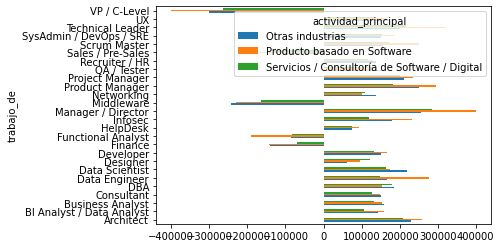

In [ ]:
# Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total
df = (
    dataframe["trabajo_de"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
    .query("trabajo_de > 0.005")
)

display(len(dataframe["trabajo_de"]) * 0.005)
chosen_roles = df.index
display(chosen_roles)


df = dataframe["trabajo_de"].value_counts(normalize=True, sort=True)
top_roles = df[:26].index

df = (
    dataframe.query("trabajo_de in @top_roles")
    .groupby(["trabajo_de", "actividad_principal"])
    .median()
    .unstack("actividad_principal")["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .fillna(0)
)  # .sort_values(by=['salario_mensual_bruto_en_tu_moneda_local'], ascending=False)

df.loc[
    df.eval("trabajo_de not in @chosen_roles"),
    [
        "Otras industrias",
        "Producto basado en Software",
        "Servicios / Consultoría de Software / Digital",
    ],
] *= -1

df.plot(kind="barh")
charts["roles_actividad_principal_salary_median"] = to_rechart(df[:30])

In [ ]:
df.head()

actividad_principal,Otras industrias,Producto basado en Software,Servicios / Consultoría de Software / Digital
trabajo_de,,,
Architect,230000.0,260000.0,210000.0
BI Analyst / Data Analyst,144500.0,160000.0,106250.0
Business Analyst,160000.0,155000.0,132000.0
Consultant,150000.0,148482.0,128540.0
DBA,185000.0,154483.0,181000.0


##### 2.2.3.3. Seniority e Industria

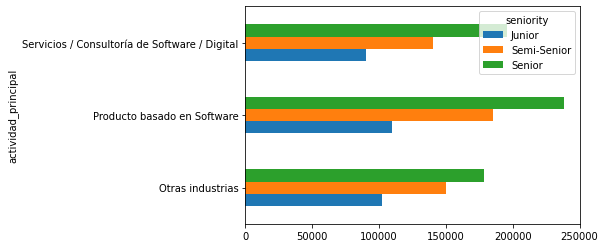

In [ ]:
df = (
    dataframe.groupby(["actividad_principal", "seniority"])
    .median()
    .unstack("seniority")["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
)  # .sort_values(by=[''],ascending=False)

df.plot.barh()
charts["actividad_principal_seniority_salary_median"] = to_rechart(df)

##### 2.2.3.2. Open source / hobbie

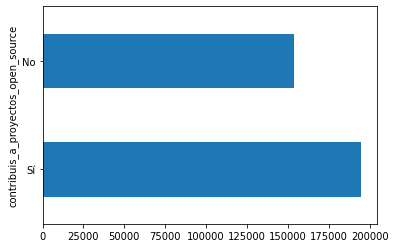

In [ ]:
df = (
    dataframe.groupby(["contribuis_a_proyectos_open_source"])
    .median()
    .unstack()["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .sort_values(ascending=False)
)

df.plot(kind="barh")
charts["opensource_salary_median"] = to_rechart(df)

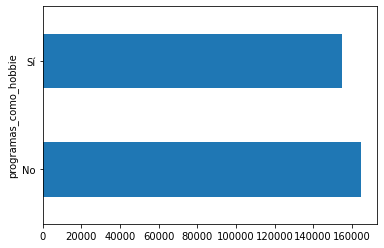

In [ ]:
df = (
    dataframe.groupby(["programas_como_hobbie"])
    .median()
    .unstack()["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .sort_values(ascending=False)
)

df.plot.barh()
charts["hobbie_salary_median"] = to_rechart(df)

#### 2.2.4. Carrera

In [ ]:
df = dataframe.groupby(["carrera", "estado"])["carrera"].count().unstack(
    "estado"
).fillna(0).sort_values(by=["Completado", "En curso"], ascending=False) / len(dataframe)

top_careers = df[:30].index

# Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total
df = df[:30]["Completado"].to_frame().query("Completado > 0.005")
display(df)
chosen_careers = df.index

,Completado
carrera,
Ingeniería en Sistemas de Información,0.029272
Analista de Sistemas,0.020933
Ingeniería en Informática,0.018550
Licenciatura en Sistemas de Información,0.010892
Diseño Gráfico,0.009190
Licenciatura en Informática,0.007488
Tecnicatura en Programación,0.006467
Tecnicatura Superior en Programación,0.006127


##### 2.2.4.1. Según Seniority

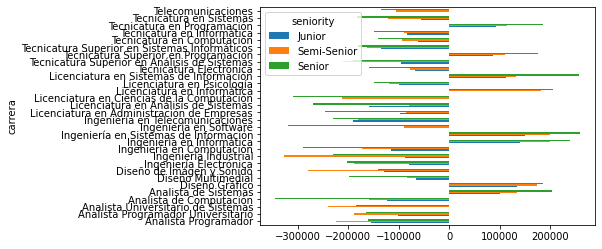

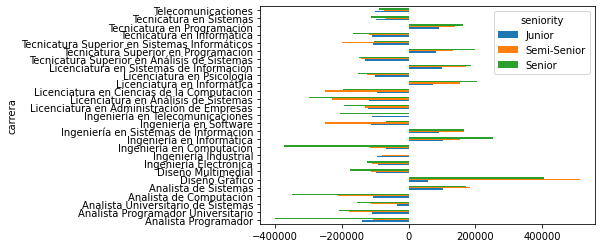

In [ ]:
df = dataframe.query('estado == "Completado"').copy()
df = invert_non_representative_values(df, "carrera", chosen_careers)
df = filter_valid_top_values(df, "carrera", top_careers)
df = get_two_dimensional_median_with_outliers_filtered(
    df, ["carrera", "seniority"], "salario_mensual_o_retiro_bruto_en_tu_moneda_local"
)

df[:30].plot(kind="barh")
charts["carrera_seniority_salary_median"] = to_rechart(df[:30])


df = dataframe.query('estado == "En curso"').copy()
df = invert_non_representative_values(df, "carrera", chosen_careers)
df = filter_valid_top_values(df, "carrera", top_careers)
df = get_two_dimensional_median_with_outliers_filtered(
    df, ["carrera", "seniority"], "salario_mensual_o_retiro_bruto_en_tu_moneda_local"
)

df[:30].plot(kind="barh")
charts["carrera_seniority_salary_median_encurso"] = to_rechart(df[:30])

In [ ]:
# Cuántos Ingenieros Industriales hay en el resultado obtenido, ya que sobresale del resto
df = dataframe.query('carrera in ["Ingeniería Industrial"] & estado == "Completado"')[
    ["seniority", "trabajo_de", "salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
].sort_values(by=["salario_mensual_o_retiro_bruto_en_tu_moneda_local"], ascending=False)

display("Un {:.2f}%".format(len(df) / len(dataframe) * 100))
display(df)

'Un 0.24%'

,seniority,trabajo_de,salario_mensual_o_retiro_bruto_en_tu_moneda_local
4644,Semi-Senior,Product Manager,774000.0
4712,Semi-Senior,Data Scientist,637402.0
6264,Senior,Manager / Director,420000.0
5414,Semi-Senior,Data Scientist,327650.0
2843,Semi-Senior,Business Analyst,320000.0
4151,Senior,Scrum Master,237400.0
203,Senior,Scrum Master,230000.0
3326,Junior,Developer,196000.0
1410,Senior,Architect,160000.0
1840,Senior,BI Analyst / Data Analyst,151000.0


In [ ]:
df

,seniority,trabajo_de,salario_mensual_o_retiro_bruto_en_tu_moneda_local
4644,Semi-Senior,Product Manager,774000.0
4712,Semi-Senior,Data Scientist,637402.0
6264,Senior,Manager / Director,420000.0
5414,Semi-Senior,Data Scientist,327650.0
2843,Semi-Senior,Business Analyst,320000.0
4151,Senior,Scrum Master,237400.0
203,Senior,Scrum Master,230000.0
3326,Junior,Developer,196000.0
1410,Senior,Architect,160000.0
1840,Senior,BI Analyst / Data Analyst,151000.0


##### 2.2.4.2. Según Estado de la Carrera

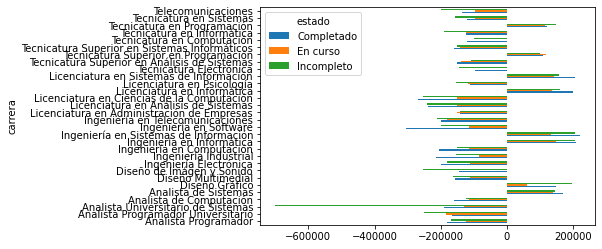

In [ ]:
df = dataframe.copy()
df = invert_non_representative_values(df, "carrera", chosen_careers)
df = filter_valid_top_values(df, "carrera", top_careers)
df = get_two_dimensional_median_with_outliers_filtered(
    df, ["carrera", "estado"], "salario_mensual_o_retiro_bruto_en_tu_moneda_local"
)

df[:30].plot(kind="barh")
charts["carrera_estado_salary_median"] = to_rechart(df[:30])

##### 2.2.4.3. Según Nivel de Estudios Alcanzado

29.38

Index(['Universitario', 'Terciario', 'Posgrado', 'Secundario', 'Doctorado'], dtype='object')

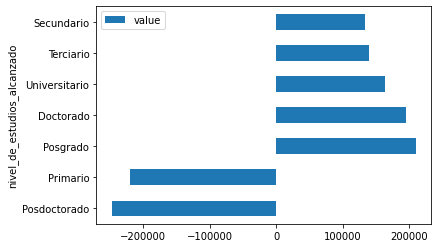

In [ ]:
# Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total
df = (
    dataframe["nivel_de_estudios_alcanzado"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
    .query("nivel_de_estudios_alcanzado > 0.005")
)

display(len(dataframe["nivel_de_estudios_alcanzado"]) * 0.005)
chosen_levels = df.index
display(chosen_levels)

df = (
    dataframe.groupby(["nivel_de_estudios_alcanzado"])
    .median()
    .unstack()["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .sort_values(ascending=False)
    .to_frame("value")
)
df.loc[df.eval("nivel_de_estudios_alcanzado not in @chosen_levels"), "value"] *= -1

df.plot(kind="barh")
charts["nivel_estudios_salary_median"] = to_rechart(df)

##### 2.2.4.4. Según hicieron o no Cursos de Especialización

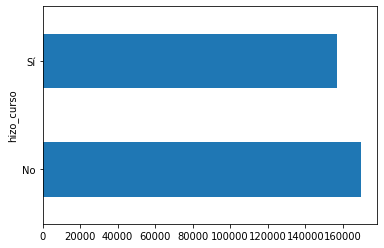

In [ ]:

dc = dataframe[
    [
        "realizaste_cursos_de_especializacion",
        "salario_mensual_o_retiro_bruto_en_tu_moneda_local",
    ]
].dropna()

mask = dc["realizaste_cursos_de_especializacion"].str.contains("Sí")
dc.loc[mask, "hizo_curso"] = "Sí"
dc.loc[~mask, "hizo_curso"] = "No"

df = (
    dc.groupby(["hizo_curso"])
    .median()
    .unstack()["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .sort_values(ascending=False)
)

df.plot(kind="barh")

charts["hizo_curso_salary_median"] = to_rechart(df)

#### 2.2.5. Tecnología

##### 2.2.5.1. Según Plataformas

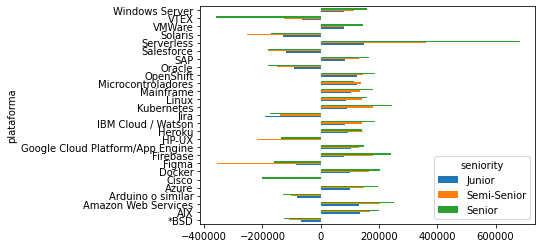

In [ ]:
# Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total
df = (
    dataframe["plataformas"]
    .str.extractall(r"(?P<count>[^,]+),? ?")["count"]
    .value_counts(normalize=True, sort=True)
)

top_platforms = df[:30].index
excluded_platforms = {"OpenStack"}  # Excluída para mantener escala
chosen_platforms = df.to_frame().query("count > 0.005").index

df = dataframe.copy()
df = (
    df["plataformas"]
    .str.split(",")
    .apply(pd.Series)
    .merge(df, right_index=True, left_index=True)
    .drop(["plataformas"], axis=1)
    .melt(
        id_vars=["seniority", "salario_mensual_o_retiro_bruto_en_tu_moneda_local"],
        value_name="plataforma",
    )
    .drop(["variable"], axis=1)
    .dropna()
    .query("plataforma in @top_platforms")
    .query("plataforma not in @excluded_platforms")
    .groupby(["plataforma", "seniority"])
    .median()
    .unstack("seniority")["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .fillna(0)
)

df.loc[
    df.eval("plataforma not in @chosen_platforms"), ["Junior", "Semi-Senior", "Senior"]
] *= -1

df = df[df.index != "Ninguna de las anteriores"]

df[:30].plot(kind="barh")
charts["plataformas_seniority_salary_median"] = to_rechart(df[:30])

##### 2.2.5.2. Según Lenguajes de Programación

seniority,Junior,Semi-Senior,Senior
lenguajes_de_programacion_o_tecnologias,,,
.NET,91000.00,150000.0,200000.0
ABAP,-94000.00,-150000.0,-166000.0
Arduino,-70000.00,-0.0,-134000.0
Bash/Shell,109000.00,171808.5,210000.0
C,80000.00,146500.0,179151.0
C#,97500.00,134091.0,178500.0
C++,58000.00,154500.0,207500.0
COBOL,-114199.00,-185000.0,-165000.0
CSS,92388.00,151000.0,199950.0


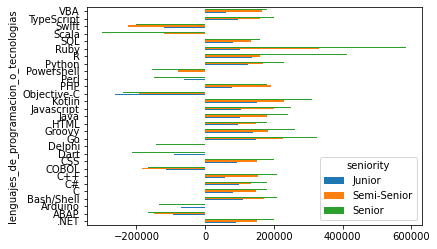

In [ ]:
#  Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total
df = (
    dataframe["lenguajes_de_programacion_o_tecnologias"]
    .str.extractall(r"(?P<count>[^,]+),? ?")["count"]
    .value_counts(normalize=True, sort=True)
)
top_languages = df[:30].index

chosen_languages = df.to_frame().query("count > 0.005").index

df = dataframe.copy()
df = (
    df["lenguajes_de_programacion_o_tecnologias"]
    .str.split(",")
    .apply(pd.Series)
    .merge(df, right_index=True, left_index=True)
    .drop(["lenguajes_de_programacion_o_tecnologias"], axis=1)
    .melt(
        id_vars=["seniority", "salario_mensual_o_retiro_bruto_en_tu_moneda_local"],
        value_name="lenguajes_de_programacion_o_tecnologias",
    )
    .drop(["variable"], axis=1)
    .dropna()
    .query("lenguajes_de_programacion_o_tecnologias in @top_languages")
    .groupby(["lenguajes_de_programacion_o_tecnologias", "seniority"])
    .median()
    .unstack("seniority")["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .fillna(0)
)

df.loc[
    df.eval("lenguajes_de_programacion_o_tecnologias not in @chosen_languages"),
    ["Junior", "Semi-Senior", "Senior"],
] *= -1

df = df[df.index != "Ninguno de los anteriores"]

display(df)
df.plot(kind="barh")
charts["lenguajes_de_programacion_seniority_salary_median"] = to_rechart(df[:30])

##### 2.2.6. Otras compensaciones

0    0.427842
dtype: float64

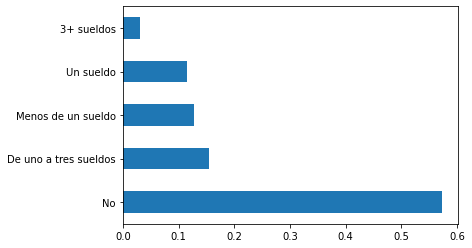

In [ ]:
df = (
    dataframe["recibis_algun_tipo_de_bono"]
    .value_counts(normalize=True, sort=True)
)

recibe_algun_tipo_de_bono = df['De uno a tres sueldos'] + df['Menos de un sueldo'] + df['Un sueldo'] + df['3+ sueldos']
recibe_algun_tipo_de_bono = pd.Series(recibe_algun_tipo_de_bono)

display(recibe_algun_tipo_de_bono)
df.plot(kind="barh")
charts["bonos_percent"] = to_rechart(df)
charts["recibe_algun_tipo_de_bono"] = to_rechart(recibe_algun_tipo_de_bono)

#### 2.2.6. Tipo de contrato

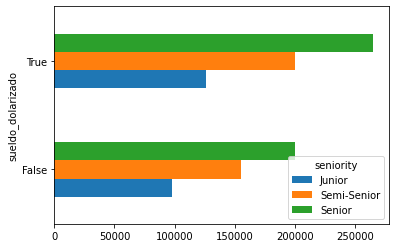

In [ ]:
df = (
    dataframe.groupby(["sueldo_dolarizado", "seniority"])
    .median()
    .unstack("seniority")["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .fillna(0)
)  # .sort_values(by=['salario_mensual_bruto_en_tu_moneda_local'], ascending=False)
df.plot(kind="barh")
charts["sueldo_dolarizado_salary_median"] = to_rechart(df)

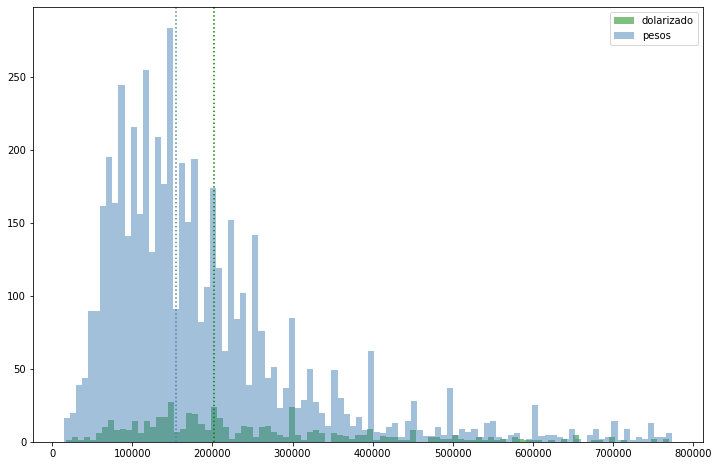

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True)
_dolar = dataframe[dataframe.sueldo_dolarizado].salario_mensual_o_retiro_bruto_en_tu_moneda_local
_no_dolar = dataframe[
    ~dataframe.sueldo_dolarizado
].salario_mensual_o_retiro_bruto_en_tu_moneda_local
ax.hist(_dolar, bins=100, label="dolarizado", alpha=0.5, color="green")
ax.hist(_no_dolar, bins=100, label="pesos", alpha=0.5, color="steelblue")
ax.axvline(_dolar.median(), color="green", linestyle="dotted")
ax.axvline(_no_dolar.median(), color="steelblue", linestyle="dotted")
ax.legend()

### 2.3. Género

#### 2.3.1. Progresión Histórica

#### 2.3.2. Preparación

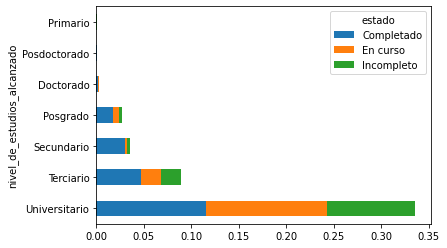

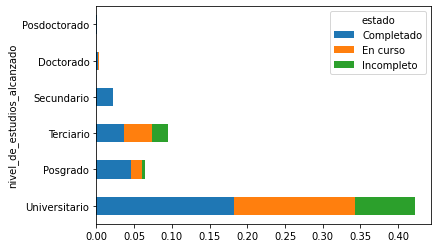

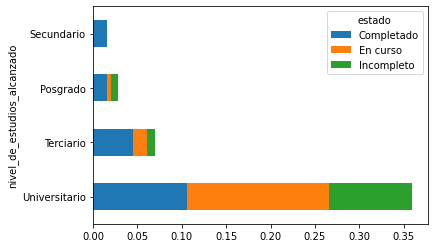

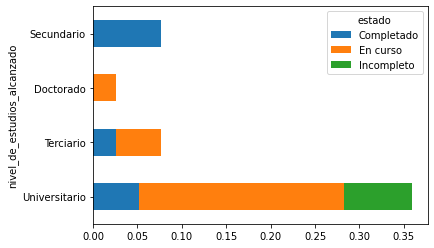

In [ ]:
df = dataframe.query('me_id_extra == "Hombre Cis"')
df = df.groupby(["nivel_de_estudios_alcanzado", "estado"])[
    "nivel_de_estudios_alcanzado"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado"], ascending=False
) / len(
    df
)
df.plot(kind="barh", stacked=True, logx=False)
charts["education_hombre_cis_stacked"] = to_rechart(df)

df = dataframe.query('me_id_extra == "Mujer Cis"')
df = df.groupby(["nivel_de_estudios_alcanzado", "estado"])[
    "nivel_de_estudios_alcanzado"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado"], ascending=False
) / len(
    df
)
df.plot(kind="barh", stacked=True, logx=False)
charts["education_mujer_cis_stacked"] = to_rechart(df)

df = dataframe.query('me_id_extra == "Prefiero No Decir"')
df = df.groupby(["nivel_de_estudios_alcanzado", "estado"])[
    "nivel_de_estudios_alcanzado"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado"], ascending=False
).sort_values(
    by=["En curso"], ascending=False
) / len(
    df
)
df.plot(kind="barh", stacked=True, logx=False)

charts["education_no_decir_stacked"] = to_rechart(df)

df = dataframe.query('me_id_extra == "No Binarie"')
df = df.groupby(["nivel_de_estudios_alcanzado", "estado"])[
    "nivel_de_estudios_alcanzado"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado"], ascending=False
).sort_values(
    by=["En curso"], ascending=False
) / len(
    df
)
df.plot(kind="barh", stacked=True, logx=False)

charts["education_no_bin_stacked"] = to_rechart(df)

#### 2.3.3. Salarios

In [ ]:
df = dataframe["trabajo_de"].value_counts(normalize=True, sort=True)
top_roles = df[:26].index

top_salary_roles = (
    dataframe.query("trabajo_de in @top_roles")
    .groupby(["trabajo_de"])
    .median()["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .fillna(0)
    .sort_values(0, ascending=False)
    .index.tolist()
)
top_salary_roles_mujer = (
    dataframe.query('trabajo_de in @top_roles & me_id_extra == "Mujer Cis"')
    .groupby(["trabajo_de"])
    .median()["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .fillna(0)
    .sort_values(0, ascending=False)
    .index.tolist()
)

# Roles mejores pagos en los que no se encuentran mujeres
display([rol for rol in top_salary_roles if rol not in top_salary_roles_mujer])

['Middleware']

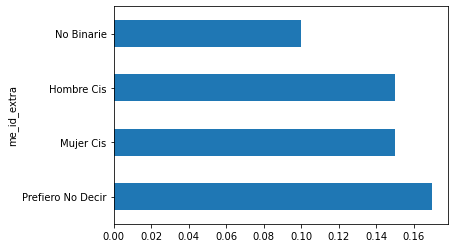

In [ ]:
df = dataframe[dataframe.me_id_extra.isin(enough_data)]
df = (
    df.groupby(["me_id_extra"])
    .median()
    .unstack()["de_que_fue_el_ajuste_total"]
    .sort_values(ascending=False)
    / 100
)

df.plot(kind="barh")
charts["gender_salary_adjustment"] = to_rechart(df)

#### 2.3.4. Experiencia

me_id_extra,Hombre Cis,Mujer Cis,No Binarie,Prefiero No Decir
actividad_principal,,,,
Otras industrias,0.805654,0.142756,0.004947,0.046643
Producto basado en Software,0.780329,0.172010,0.007366,0.040295
Servicios / Consultoría de Software / Digital,0.765235,0.184316,0.007493,0.042957


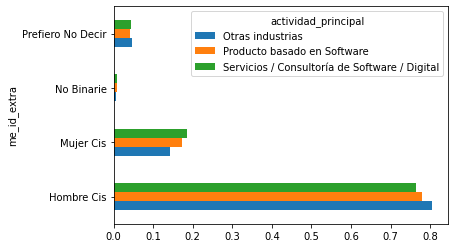

In [ ]:
df = dataframe[dataframe.me_id_extra.isin(enough_data)]
df = (
    df.groupby(["actividad_principal", "me_id_extra"])
    .agg({"me_id_extra": "count"})
    .groupby(level=0)
    .apply(lambda x: x / float(x.sum()))
    .unstack("me_id_extra")
)
df.columns = df.columns.droplevel(0)

display(df)
df.T.plot(kind="barh")
charts["actividad_principal_gender_percent"] = to_rechart(df)

me_id_extra,Hombre Cis,Mujer Cis,No Binarie,Prefiero No Decir
anos_de_experiencia_fibo,,,,
0-1,0.741772,0.215190,0.015190,0.027848
2,0.743289,0.214765,0.005034,0.036913
3,0.757798,0.211009,0.003670,0.027523
4-5,0.782716,0.171605,0.008642,0.037037
6-8,0.791483,0.151248,0.005874,0.051395
9-13,0.817495,0.138229,0.005400,0.038877
14-21,0.842593,0.093621,0.004115,0.059671
22-55,0.838596,0.087719,0.007018,0.066667


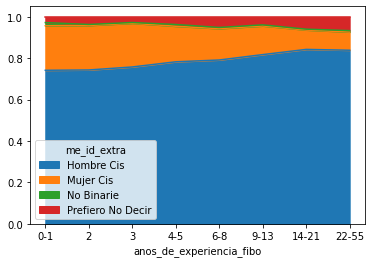

In [ ]:
df = dataframe.copy()
df = df[df.me_id_extra.isin(enough_data)]
df["anos_de_experiencia_fibo"] = pd.cut(
    df["anos_de_experiencia"].values,
    [0, 1, 2, 3, 5, 8, 13, 21, 55],
    labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-55"],
)
df = (
    df.groupby(["anos_de_experiencia_fibo", "me_id_extra"])
    .agg({"me_id_extra": "count"})
    .groupby(level=0)
    .apply(lambda x: x / float(x.sum()))
    .unstack("me_id_extra")
    .fillna(0)
)
df.columns = df.columns.droplevel(0)
display(df)
df.plot(kind="area")
charts["experience_gender_percent"] = to_rechart(df)

me_id_extra,Hombre Cis,Mujer Cis,No Binarie,Prefiero No Decir
anos_de_experiencia_fibo,,,,
0-1,100000.0,86000.0,120000.0,150000.0
2,130000.0,120000.0,192000.0,138073.0
3,157000.0,140000.0,262500.0,120000.0
4-5,176497.0,145000.0,100000.0,152250.0
6-8,189646.0,164000.0,200000.0,167800.0
9-13,200000.0,200000.0,158653.0,241000.0
14-21,210000.0,180000.0,159000.0,217000.0
22-55,208000.0,175000.0,350000.0,200000.0


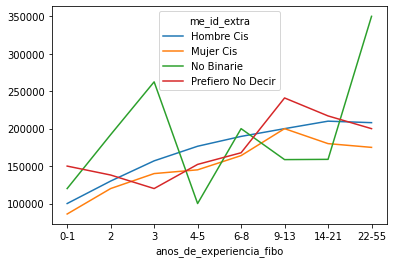

In [ ]:
df = dataframe.copy()
df = df[df.me_id_extra.isin(enough_data)]

df["anos_de_experiencia_fibo"] = pd.cut(
    df["anos_de_experiencia"].values,
    [0, 1, 2, 3, 5, 8, 13, 21, 55],
    labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-55"],
)
df = (
    df.groupby(["anos_de_experiencia_fibo", "me_id_extra"])
    .agg({"salario_mensual_o_retiro_bruto_en_tu_moneda_local": "median"})
    .unstack("me_id_extra")
    .fillna(0)
)
df.columns = df.columns.droplevel(0)
display(df)
df.plot(kind="line")
charts["experience_gender_salary_median"] = to_rechart(df)

me_id_extra,Hombre Cis,Mujer Cis,No Binarie,Prefiero No Decir
anos_de_experiencia_fibo,,,,
0-1,2.757679,2.682353,3.000000,2.818182
2,2.733634,2.820312,3.000000,2.727273
3,2.786925,2.756522,3.500000,2.266667
4-5,2.761830,2.690647,2.714286,2.633333
6-8,2.781076,2.805825,3.250000,2.771429
9-13,2.734478,2.843750,2.000000,2.611111
14-21,2.692308,2.725275,2.500000,2.568966
22-55,2.619247,2.720000,3.500000,2.631579


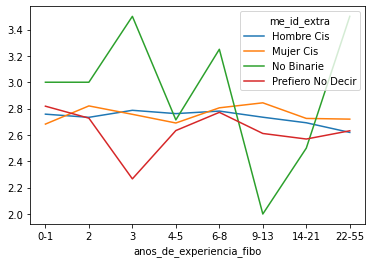

In [ ]:
df = dataframe.copy()
df = df[df.me_id_extra.isin(enough_data)]

df["anos_de_experiencia_fibo"] = pd.cut(
    df["anos_de_experiencia"].values,
    [0, 1, 2, 3, 5, 8, 13, 21, 55],
    labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-55"],
)
df = (
    df.groupby(["anos_de_experiencia_fibo", "me_id_extra"])
    .agg({"que_tan_conforme_estas_con_tu_sueldo": "mean"})
    .unstack("me_id_extra")
    .fillna(0)
)
df.columns = df.columns.droplevel(0)
display(df)
df.plot(kind="line")
charts["experience_gender_conformidad_mean"] = to_rechart(df)

#### 2.3.5. Discapacidad

0    0.965793
dtype: float64

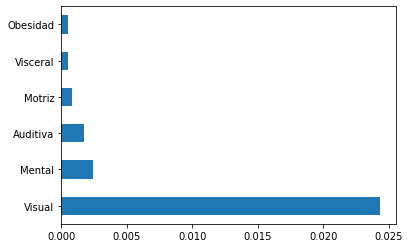

In [ ]:
df = dataframe["tenes_algun_tipo_de_discapacidad"].fillna("No reporta").value_counts(
    normalize=False, sort=True
) / len(dataframe)
no_reporta = df['No reporta']
no_reporta = pd.Series(no_reporta)
df = df.drop(labels=['No reporta'])


df[:6].plot(kind="barh")
display(no_reporta)
charts["discapacidad_percent"] = to_rechart(df, 7)
charts["n_persons_with_no_disabilities"] = to_rechart(no_reporta)

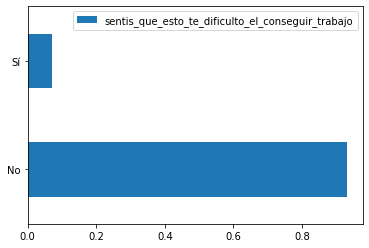

In [ ]:
# Quienes respondieron Sí o No, son quienes contestaron sobre discapacidad.  El resto es None
df = (
    dataframe["sentis_que_esto_te_dificulto_el_conseguir_trabajo"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
)

df.plot(kind="barh")
charts["discapacidad_dificultad_percent"] = to_rechart(df)

### 2.4. Tecnología

#### 2.4.1. Plataformas más populares

'reduced in 0.017903'

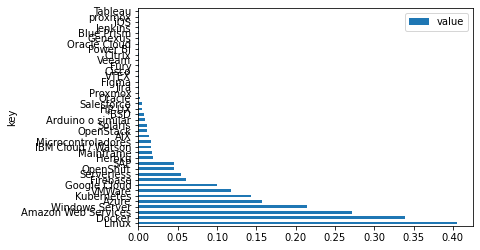

In [ ]:
df = (
    dataframe["plataformas"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        "Google Cloud Platform/App Engine": "Google Cloud",
        "Sap": "SAP",
        "crm": "CRM",
        "Ninguna de las anteriores": "Ninguna/Ninguno",
        "^(nada|no|ningun[ao]|otros?|0|-|\.)$": "DELETEME",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df = df[df.index != "Ninguna/Ninguno"]

df[:40].plot.barh()
charts["plataformas"] = to_rechart(df[:40])

#### 2.4.2. Lenguajes de Programación más populares

'reduced in 0.033175'

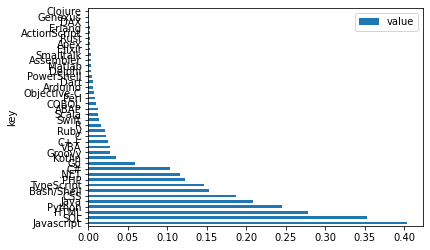

In [ ]:
df = (
    dataframe["lenguajes_de_programacion_o_tecnologias"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        "powershell": "PowerShell",
        "cobol": "COBOL",
        "Ninguno de los anteriores": "Ninguna/Ninguno",
        "^(nada|no|ningun[ao]|otros?|-|\.)$": "DELETEME",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df = df[df.index != "Ninguna/Ninguno"]

df[:40].plot.barh()
charts["lenguajes_de_programacion"] = to_rechart(df[:40])

#### 2.4.3. Frameworks, Herramientas y Librerías más populares

'reduced in 0.047222'

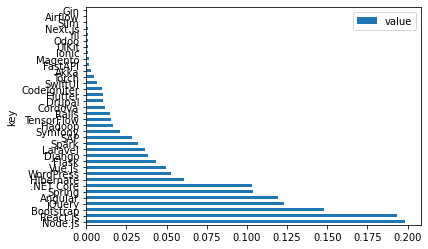

In [ ]:
df = (
    dataframe["frameworksherramientas_y_librerias"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        ".*(node).*$": "Node.js",
        ".*Angular.*$": "Angular",
        ".*React.*$": "React.js",
        ".*Vue.*$": "Vue.js",
        ".*jquery.*$": "jQuery",
        ".*laravel.*$": "Laravel",
        ".*codeigniter.*$": "CodeIgniter",
        ".*struts.*$": "Struts",
        "Ninguno de los anteriores": "Ninguna/Ninguno",
        "^(nada|no|ningun[ao]|otros?|0|-|\.)$": "DELETEME",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df = df[df.index != "Ninguna/Ninguno"]

df[:36].plot.barh()
charts["frameworksherramientas_y_librerias"] = to_rechart(df[:36])

#### 2.4.4. Bases de Datos más populares

'reduced in 0.041176'

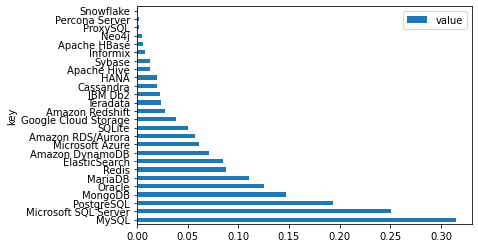

In [ ]:
df = (
    dataframe["bases_de_datos"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        ".*(sybase).*$": "Sybase",
        "Microsoft Azure \(Tables": "Microsoft Azure",
        "Ninguna de las anteriores": "Ninguna/Ninguno",
        "^(SQL|CosmosDB|etc\)|otros?|0|-|\.)$": "DELETEME",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df = df[df.index != "Ninguna/Ninguno"]

df[:26].plot.barh()
charts["bases_de_datos"] = to_rechart(df[:26])

#### 2.4.5. Herramientas de QA / Testing más populares

'reduced in 0.197248'

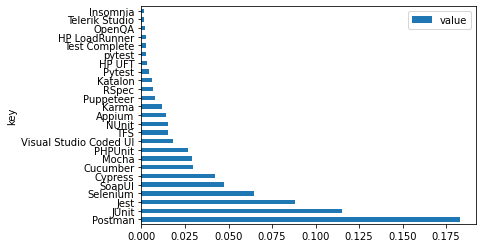

In [ ]:
df = (
    dataframe["qa_testing"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        ".*(ningun[oa]|no|nada|otros?|0|\.).*$": "DELETEME",
        ".*(junit).*$": "JUnit",
        ".*(jest).*$": "Jest",
        "Ninguna de las anteriores": "Ninguna/Ninguno",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df = df[df.index != "Ninguna/Ninguno"]

df[:25].plot.barh()
charts["qa_testing"] = to_rechart(df[:25])

#### 2.4.6. IDEs más populares

'reduced in 0.119718'

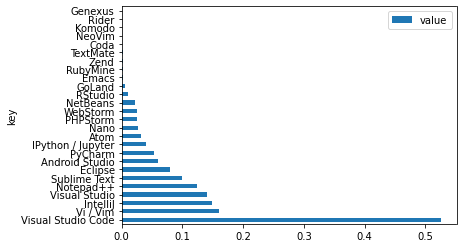

In [ ]:
df = (
    dataframe["ides"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        "^.*(Visual Studio|VS).*$": "Visual Studio",
        "^.*(Visual Studio Code|VS ?Code|Code).*$": "Visual Studio Code",
        ".*(Sublime)( Text)?.*$": "Sublime Text",
        ".*(webstorm).*$": "WebStorm",
        "^(vi|vim)$": "Vi / Vim",
        "^(jdeveloper)$": "JDeveloper",
        "^(goland)$": "GoLand",
        "^(neovim)$": "NeoVim",
        "IBM integración toolkit": "IBM Integration Bus",
        "^(rubymine)$": "RubyMine",
        "Ninguno de los anteriores": "Ninguna/Ninguno",
        "^(no( uso.*| util.*)?|none|ningun[ao]|0|No s[eé]|nada|-|\.)$": "DELETEME",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df = df[df.index != "Ninguna/Ninguno"]

df[:26].plot.barh()
charts["ides"] = to_rechart(df[:26])

### 2.5. Trabajo

#### 2.5.1. Tipos de contrato

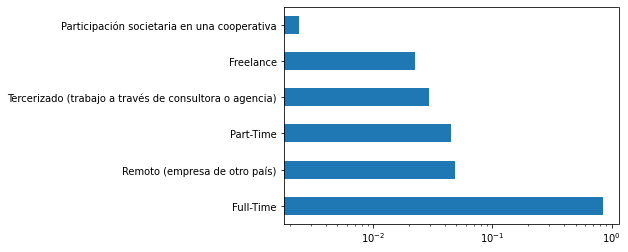

In [ ]:
df = dataframe["tipo_de_contrato"].value_counts(normalize=True, sort=True)

df.plot(kind="barh", logx=True)
charts["tipo_de_contrato_percent"] = to_rechart(df)

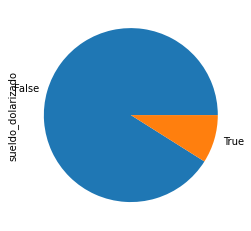

In [ ]:
df = dataframe["sueldo_dolarizado"].value_counts(normalize=True, sort=True)
df.plot.pie()
charts["sueldo_dolarizado_percent"] = to_rechart(df)

#### 2.5.2. Compensación

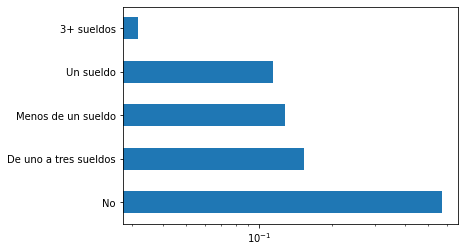

In [ ]:
#DUPLICADO DEL 2.2.6
df = dataframe["recibis_algun_tipo_de_bono"].value_counts(normalize=True, sort=True)

df.plot(kind="barh", logx=True)
charts["recibis_algun_tipo_de_bono"] = to_rechart(df)

'reduced in 0.197880'

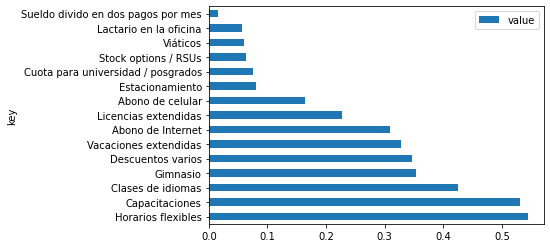

In [ ]:
df = (
    dataframe["beneficios_extra"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        "(.*Vacaciones flexibles.*|Días off|.*cumpleaños libre.*|.*Día libre.*)$": "Vacaciones extendidas",
        ".*Licencias?.*$": "Licencias extendidas",
        "horarios? flexibles?$": "Horarios flexibles",
        "(.*capacitaci[oó]n(es)?.*|.*cursos?.*)$": "Capacitaciones",
        "bebidas?$": "Bebidas",
        "(golosinas?|.*snac?ks?|Snacks)$": "Snacks",
        ".*(Clarín 365).*$": "Descuentos varios",
        "(.*Descuentos varios.*|.*gift card)": "Descuentos varios",
        "0": "DELETEME",
        "(etc\)|Club La Nación)$": "DELETEME",
        ".que tiene que ver el tema": "DELETEME",
        "(no|.*Nada.*|Ning[uú]n[ao]?( de las anteriores)?)$": "DELETEME",
        "(.*prepaga.*|OSDE|.*obra social.*)$": "Prepaga",
        "(frut[ao]s?)$": "Frutas",
        "(facturas?)": "Facturas",
        "(.*home off?ice.*|.*WFH.*|.*home work.*|100% remoto|Remoto|Full remote)$": "WFH",
        "(.*d[oó]lares.*|Sueldo dolarizado)$": "Sueldo dolarizado",
        "(.*gimnasio.*|.*gym.*)$": "Gimnasio",
        "(.*cochera.*|.*estacionamiento.*)$": "Estacionamiento",
        "(.*combustibles?.*|.*vi[aá]ticos?.*|.*cabify.*|.*transporte.*|.*remis.*|.*turismo.*|.*vuelos.*)$": "Viáticos",
        "(.*sueldos? ex.*)$": "Sueldos extra",
        "(.*eventos?.*|entradas?)$": "Eventos",
        "(.*pileta)$": "Pileta",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df[:15].plot.barh()
charts["beneficios_extra"] = to_rechart(df[:15])

0-1       0.271784
2         0.000851
3         0.003744
4-5       0.015657
6-8       0.026719
9-13      0.124404
14-21     0.210517
22-34     0.185500
35-55     0.132914
56-89     0.014466
90-144    0.006637
Name: de_que_fue_el_ajuste_total, dtype: float64

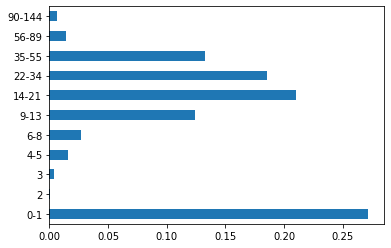

In [ ]:
df = dataframe["de_que_fue_el_ajuste_total"].copy()
df = df.groupby(
    pd.cut(
        df.values,
        [0, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144],
        labels=[
            "0-1",
            "2",
            "3",
            "4-5",
            "6-8",
            "9-13",
            "14-21",
            "22-34",
            "35-55",
            "56-89",
            "90-144",
        ],
        include_lowest=True,
    )
).count() / len(df)
display(df)
df.plot.barh()
charts["de_que_fue_el_ajuste"] = to_rechart(df.sort_index())

#### 2.5.3. Características de la Empresa

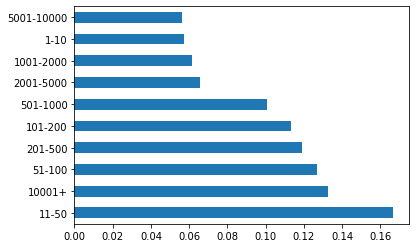

In [ ]:
df = dataframe["cantidad_de_personas_en_tu_organizacion"].value_counts(normalize=True, sort=True)

df.plot(kind="barh", logx=False)
charts["cantidad_de_personas_en_tu_organizacion"] = to_rechart(df)

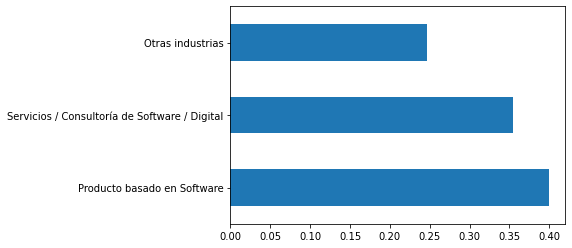

In [ ]:
df = dataframe["actividad_principal"].value_counts(normalize=True, sort=True)

df.plot(kind="barh", logx=False)
charts["actividad_principal"] = to_rechart(df)

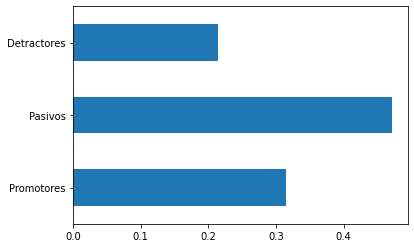

In [ ]:
df = dataframe["la_recomendas_como_un_buen_lugar_para_trabajar"].copy()
# https://es.wikipedia.org/wiki/Net_Promoter_Score
df = df.groupby(
    pd.cut(df.values, [0, 6, 8, 10], labels=["Detractores", "Pasivos", "Promotores"])
).count() / len(df)
df = df.iloc[::-1]  # reverse order

df.plot.barh()
charts["la_recomendas_como_un_buen_lugar_para_trabajar"] = to_rechart(df)

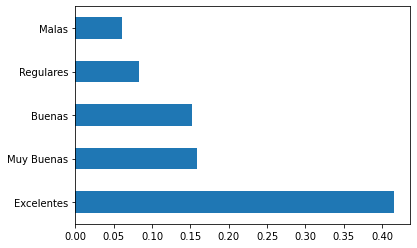

In [ ]:
df = dataframe["como_calificas_las_politicas_de_diversidad_e_inclusion"]
df = df.groupby(
    pd.cut(
        df.values,
        [0, 3, 5, 7, 8, 10],
        labels=["Malas", "Regulares", "Buenas", "Muy Buenas", "Excelentes"],
    )
).count() / len(df)
df = df.iloc[::-1]

df.plot.barh()
charts["politicas_diversidad_e_inclusion"] = to_rechart(df)

'reduced in 0.132495'

,value
key,
Quarkslab,0.155208
MercadoLibre,0.152655
Globant,0.052417
Medallia,0.019571
Accenture,0.013104
Google,0.012934
MuleSoft,0.009020
Santander,0.008509
Salesforce,0.008509


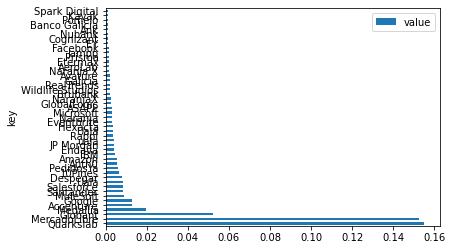

In [ ]:
#Verificar esta celda de codigo. Para el set 2021.02 hay un registro que trae en el campo "cuales_consideras...." la palabra 'Quarkslab' muchas veces separado por coma
# por eso para este set, la empresa Quarkslab aparece como puntera con el 15%
df = (
    dataframe[
        "cuales_consideras_que_son_las_mejores_empresas_de_it_para_trabajar_en_este_momentoen_tu_ciudad"
    ]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        "^(ningun[ao]|-|no lo se|desconozco|ni idea|no s[ée]|Son todas una mierda\.|bancos?)$": "DELETEME",
        "^(mercadolibre|mercado libre|meli|ml|mercado ?pago)$": "MercadoLibre",
        "^(medallia|medalia)$": "Medallia",
        "^(despegar\.?(com)?)$": "Despegar",
        "^(mulesoft)$": "Mulesoft",
        "^(globant)$": "Globant",
        "^(google)$": "Google",
        "^(auth0)$": "Auth0",
        "^(rappi)$": "Rappi",
        "^(jampp?)$": "Jampp",
        "^(asapp|asap)$": "ASAPP",
        "^(ibm|i\.b\.m\.?)$": "IBM",
        "^(aws|amazon)$": "Amazon",
        "^(eventbrite)$": "Eventbrite",
        "^(saleforce|salesforce)$": "Salesforce",
        "^(olx|o\.l\.x\.?)$": "OLX",
        "^(10 ?pines)$": "10Pines",
        "^(microsoft)$": "Microsoft",
        "^(jp ?morgan)$": "JP Morgan",
        "^(elementum)$": "Elementum",
        "^(bell?atrix)$": "Belatrix",
        "^(nubank)$": "Nubank",
        "^(etermax)$": "Etermax",
        "^(facebook)$": "Facebook",
        "^(hexacta)$": "Hexacta",
        "^(oracle)$": "Oracle",
        "^(avature)$": "Avature",
        "^(everis)$": "Everis",
        "^(baires ?dev)$": "NubaBairesDevnk",
        "^(stensul)$": "Stensul",
        "^(satel? ?logic\.?)$": "Satellogic",
        "^(scale)$": "Scale",
        "^(aerolab)$": "AeroLab",
        "^(rga|r/ga)$": "R/GA",
        "^(accenture)$": "Accenture",
        "^(olapic)$": "Olapic",
        "^(logicalis)$": "Logicalis",
        "^(mule ?(soft)?)$": "MuleSoft",
        "^(soft ?vision)$": "SoftVision",
        "^(global ?logic)$": "GlobalLogic",
        "^(pedidos ?ya)$": "PedidosYa",
        "^(decentra ?land)$": "DecentraLand",
        "^(real ?trends)$": "RealTrends",
        "^(nubi ?lmetri(x|cs))$": "Nubimetrics",
        "^(santander( tec.*))$": "Santander",
        "^(wildlife|wildlife*)$": "Wildlife Studios",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)
display(df[:47])
df[:47].plot.barh()

#### Distribución de los roles mejor pagos

In [ ]:
dataframe_top10=dataframe.copy()
dataframe_top10['sueldo_total_o_parcial_en_dolares']=~pd.isna(dataframe_top10['pagos_en_dolares'])*1

q90=dataframe_top10['salario_mensual_o_retiro_bruto_en_tu_moneda_local'].quantile(.90)

# nos quedamos con el top 10% de los que mas ganan
salario_top10=dataframe_top10[(dataframe_top10['salario_mensual_o_retiro_bruto_en_tu_moneda_local'] > q90)]


sub_set=pd.DataFrame({'Cantidad' : salario_top10.groupby('trabajo_de').size() ,
              'Promedio' : round(salario_top10.groupby(["trabajo_de"])["salario_mensual_o_retiro_bruto_en_tu_moneda_local"].mean()),
              'Mediana' : salario_top10.groupby(["trabajo_de"])["salario_mensual_o_retiro_bruto_en_tu_moneda_local"].median(),
              'Porcentaje_dolarizados' : round(salario_top10.groupby(["trabajo_de"])["sueldo_total_o_parcial_en_dolares"].mean(),2)
                })

sub_set = sub_set.sort_values('Mediana',ascending=False)
sub_set = sub_set.query("Cantidad >= 5")
sub_set
charts["salary_by_role_top10_perc"] = to_rechart(sub_set)

In [ ]:
sub_set

,Cantidad,Promedio,Mediana,Porcentaje_dolarizados
trabajo_de,,,,
SysAdmin / DevOps / SRE,48,528570.0,512612.5,0.62
Developer,189,533302.0,504000.0,0.88
VP / C-Level,10,525721.0,500000.0,0.60
Manager / Director,95,504713.0,500000.0,0.22
Infosec,7,476266.0,475000.0,0.29
Architect,29,487164.0,470700.0,0.41
Data Engineer,8,523088.0,454850.0,0.75
Technical Leader,84,491732.0,450000.0,0.55
QA / Tester,25,502462.0,450000.0,0.88


Notar que la explicación de que QA esté tan arriba en la mediana se debe al gran porcentaje de sueldos dolarizados.

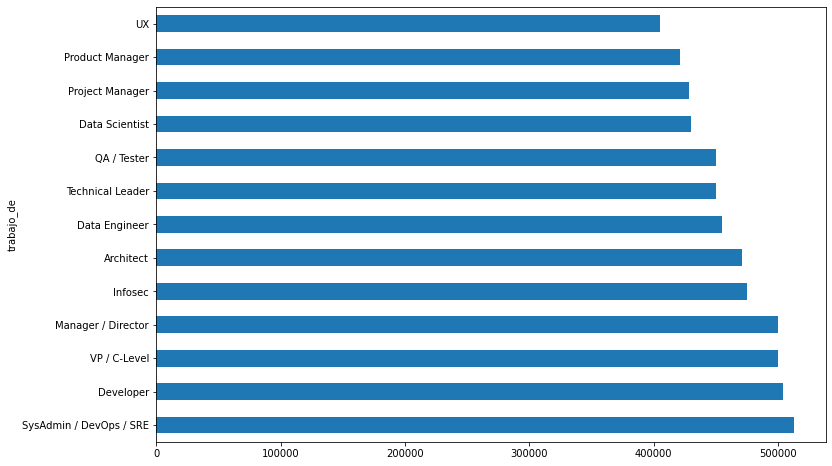

In [ ]:
sub_set=sub_set.sort_values('Mediana',ascending=False)

plt.figure(figsize=(12, 8))
sub_set['Mediana'].plot(kind="barh", ax=plt.gca())
charts["salary_by_role_top10"] = to_rechart(sub_set)

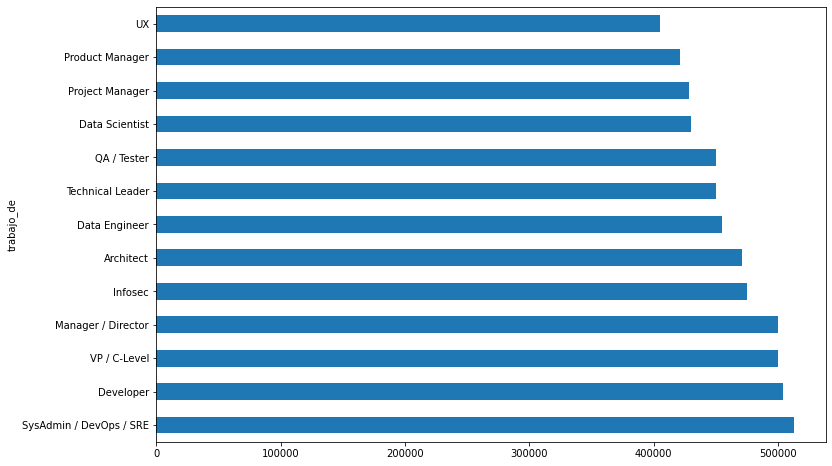

In [ ]:
#solo con la mediana
sub_set = sub_set[['Mediana']]
plt.figure(figsize=(12, 8))
sub_set['Mediana'].plot(kind="barh", ax=plt.gca())
charts["salary_by_role_top10"] = to_rechart(sub_set)

Variable 'me_identifico' con posiciones de liderazgo (a cargo una o mas personas)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


me_id_extra,Hombre Cis,Mujer Cis,No Binarie,Prefiero No Decir
tiene_gente_a_cargo,,,,
No,0.736195,0.798554,0.794872,0.726531
Sí,0.263805,0.201446,0.205128,0.273469


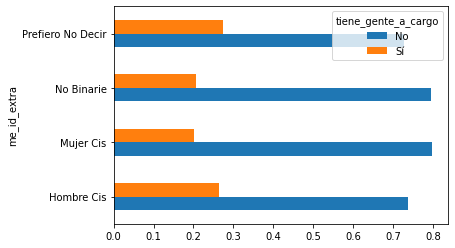

In [ ]:
import numpy as np
dataframe['tiene_gente_a_cargo']=np.where(dataframe['gente_a_cargo']>=1, "Sí", "No")

df = dataframe[dataframe.me_id_extra.isin(enough_data)]
df = (
    df[[ "me_id_extra","tiene_gente_a_cargo"]]
    .value_counts(normalize=True, sort=True)
    .groupby(level=0)
    .apply(lambda x: x / float(x.sum()))
    .unstack("me_id_extra")
)

display(df)
df.T.plot(kind="barh")
charts["leadership_gender_percent"] = to_rechart(df)

In [ ]:
dataframe[["me_id_extra"]].value_counts(normalize=True, sort=True)

me_id_extra      
Hombre Cis           0.778590
Mujer Cis            0.168494
Prefiero No Decir    0.042646
No Binarie           0.006789
Hombre Trans         0.001741
Mujer Trans          0.001567
Agénero              0.000174
dtype: float64

'Cantidad de hijos' y sueldo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


me_id_extra,Hombre Cis,Mujer Cis,No Binarie,Prefiero No Decir
tenes_hijos_menores_str,,,,
No,163800.0,130750.0,140000.0,156000.0
Si,210000.0,160500.0,252000.0,250000.0


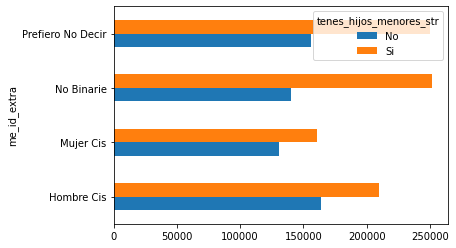

In [ ]:
import numpy as np
dataframe['tenes_hijos_menores_str']=np.where(dataframe['tenes_hijosas_menores_de_edad']>=1, "Si", "No")

df = dataframe[dataframe.me_id_extra.isin(enough_data)]
df = (
    df.groupby(["me_id_extra", "tenes_hijos_menores_str"])
    .median()["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .unstack("me_id_extra")
)

display(df)
df.T.plot(kind="barh")
#df.plot(kind="barh")

Diferencias en el ranking entre lenguajes de programacion (dataset previo y 2021.02)

In [ ]:
#tomamos datos previos y normalizamos
csv_url = "https://raw.githubusercontent.com/openqube/openqube-sueldos/release/2020.02/data/csv/argentina/2017.02.csv"


raw_dataframe = None
source = requests.get(
    csv_url.format(dataset_metadata["year"], dataset_metadata["part"])
).content
raw_dataframe = pd.read_csv(
   io.StringIO(source.decode("utf-8")),
    skiprows=dataset_metadata["skiprows"],
    thousands=".",
   decimal=",",
)


# resultados que no pertenezcan a Argentina quedan fuera de este análisis
columns_to_remove = [
    "Bolivia",
    "Chile",
    "Colombia",
    "Cuba",
    "Costa Rica",
    "Ecuador",
    "El Salvador",
    "Guatemala",
    "Honduras",
    "México",
    "Nicaragua",
    "Panamá",
    "Paraguay",
    "Perú",
    "Puerto Rico",
    "República Dominicana",
    "Uruguay",
    "Venezuela",
]

#raw_dataframe.drop(columns_to_remove, axis=1, inplace=True)

import re

regex_white_chars = re.compile(r"\s+")
regex_non_alphanum = re.compile(r"\W+_?", re.I)

raw_dataframe.columns = (
    raw_dataframe.columns.str.strip()
    .str.lower()
    .str.replace(regex_white_chars, "_")
    .str.replace(regex_non_alphanum, "")
    .str.translate(
        "ñáéíóú".maketrans({"ñ": "n", "á": "a", "é": "e", "í": "i", "ó": "o", "ú": "u"})
    )
)

# Eliminamos los datos que no pertenezcan a Argentina
#raw_dataframe = raw_dataframe[raw_dataframe["estoy_trabajando_en"] == "Argentina"]

dataframe_prev = raw_dataframe.copy()

#display([column for column in dataframe202101.columns])

In [ ]:
df01 = (
    dataframe_prev["tecnologias_que_utilizas1"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df01.reset_index(level=0, inplace=True)

df01 = normalize_dataframe_column(
    df01,
    "key",
    {
        "powershell": "PowerShell",
        "cobol": "COBOL",
        "Ninguno de los anteriores": "Ninguna/Ninguno",
        "^(nada|no|ningun[ao]|otros?|-|\.)$": "DELETEME",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df01 = df01.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe_prev)

df01 = df01[df01.index != "Ninguna/Ninguno"]
df01=df01[:15]
df01=df01.rank(method='first',ascending=False)

#df[:40].plot.barh()

'reduced in 0.051546'

In [ ]:
df02 = (
    dataframe["lenguajes_de_programacion_o_tecnologias"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df02.reset_index(level=0, inplace=True)

df02 = normalize_dataframe_column(
    df02,
    "key",
    {
        "powershell": "PowerShell",
        "cobol": "COBOL",
        "Ninguno de los anteriores": "Ninguna/Ninguno",
        "^(nada|no|ningun[ao]|otros?|-|\.)$": "DELETEME",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df02 = df02.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df02 = df02[df02.index != "Ninguna/Ninguno"]
df02=df02[:15]
df02=df02.rank(method='first',ascending=False)
#df[:40].plot.barh()

'reduced in 0.033175'

In [ ]:
leng_rank=pd.merge(df01,df02,on='key')
leng_rank.rename(columns={'value_x': "2017.02","value_y":"2021.02"},inplace=True)
leng_rank['Diferencia'] = leng_rank['2017.02'] - leng_rank['2021.02']
display(leng_rank)
#charts["prog_lang_rank"] = to_rechart(leng_rank)

,2017.02,2021.02,Diferencia
key,,,
Javascript,1.0,1.0,0.0
HTML,2.0,3.0,-1.0
CSS,4.0,6.0,-2.0
Java,5.0,5.0,0.0
PHP,6.0,9.0,-3.0
.NET,7.0,10.0,-3.0
Python,8.0,4.0,4.0
C#,10.0,11.0,-1.0


## 3. Publicación

In [ ]:
import json

# formateamos valores flotantes para ahorrar caracteres (#macritips)
display(
    json.dumps(
        json.loads(
            json.dumps(charts, allow_nan=False),
            parse_float=lambda x: round(float(x), 5),
        )
    )
)

'{"total_surveyed": 6410, "total_analyzed_surveyed": 5876, "regions_percent": {"data": [{"name": "Ciudad Aut\\u00f3noma de Buenos Aires", "value": 0.55633}, {"name": "Buenos Aires", "value": 0.20524}, {"name": "C\\u00f3rdoba", "value": 0.07982}, {"name": "Santa Fe", "value": 0.06297}, {"name": "Mendoza", "value": 0.02383}, {"name": "Entre R\\u00edos", "value": 0.00987}, {"name": "R\\u00edo Negro", "value": 0.00783}, {"name": "Tucum\\u00e1n", "value": 0.00766}, {"name": "Neuqu\\u00e9n", "value": 0.00715}, {"name": "Chaco", "value": 0.00647}, {"name": "Misiones", "value": 0.00579}, {"name": "Salta", "value": 0.00425}, {"name": "San Juan", "value": 0.00357}, {"name": "Chubut", "value": 0.00323}, {"name": "Jujuy", "value": 0.00323}, {"name": "Corrientes", "value": 0.00306}, {"name": "La Rioja", "value": 0.00221}, {"name": "San Luis", "value": 0.0017}, {"name": "Tierra del Fuego", "value": 0.0017}, {"name": "La Pampa", "value": 0.00136}, {"name": "Santiago del Estero", "value": 0.00136}, {"

In [ ]:
#import json
#with open('charts.json', 'w', encoding='utf-8') as f:
#    json.dump(charts, f, ensure_ascii=False, indent=4, default=str)

Exportar datos preparados a Google Sheets

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials
from gspread_dataframe import get_as_dataframe, set_with_dataframe

gc = gspread.authorize(GoogleCredentials.get_application_default())

sh = gc.create('/content/drive/MyDrive/Colab Notebooks/encuesta_sysarmy/encuesta_clean_202102')

# Open our new sheet and add some data.
worksheet = gc.open('encuesta_clean_202102').sheet1

set_with_dataframe(worksheet, dataframe) 



Existe un 45% de aumento en la mediana salarial respecto al período anterior (2021.01).
Para verificar la integridad de los datos, graficamos el histograma de la variable salario, junto a los quintiles. Luego replicamos este mismo análisis con los datos de la encuesta anterior (2021.01) y verificamos que los valores eran similares.

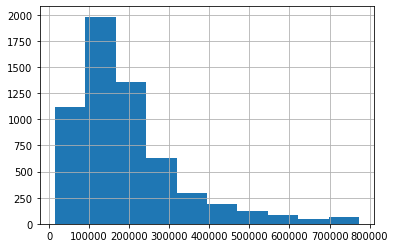

In [ ]:
dataframe['salario_mensual_o_retiro_bruto_en_tu_moneda_local'].hist()

In [ ]:
display(dataframe['salario_mensual_o_retiro_bruto_en_tu_moneda_local'].quantile(.2))
display(dataframe['salario_mensual_o_retiro_bruto_en_tu_moneda_local'].quantile(.4))
display(dataframe['salario_mensual_o_retiro_bruto_en_tu_moneda_local'].quantile(.6))
display(dataframe['salario_mensual_o_retiro_bruto_en_tu_moneda_local'].quantile(.8))
display(dataframe['salario_mensual_o_retiro_bruto_en_tu_moneda_local'].mean())

94892.0

140000.0

185000.0

260090.0

194581.03027399594

In [ ]:
#Respecto a 2021.01
#el promedio vario 46%
#el percentil 80 varió 44%
#el percentil 60 varió 42%
#el percentil 20 varió 40%